In [1]:
# Cell 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
from transformers import ViTModel
from time import time
import json
from pathlib import Path
import logging
from tqdm import tqdm

In [2]:
# Cell 2: Configure Logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)


In [3]:
# Cell 3: Configuration Class
class Config:
    IMG_SIZE = 384  # ViT-Large-384 native resolution
    BATCH_SIZE = 8  # Optimized for P100 16GB
    EPOCHS = 25
    LEARNING_RATE = 1e-4
    NUM_WORKERS = 4
    PIN_MEMORY = True
    GRADIENT_ACCUMULATION_STEPS = 2
    USE_AMP = True
    EARLY_STOPPING_PATIENCE = 5
    TRAIN_PATH = '../input/aptos2019/train_images'
    TEST_PATH = '../input/aptos2019/test_images'
    TRAIN_CSV = '../input/aptos2019/train.csv'
    TEST_CSV = '../input/aptos2019/test.csv'
    CHECKPOINT_DIR = Path("./checkpoints")
    CHECKPOINT_FREQ = 5
    FINETUNE_EPOCHS = 15
    FINETUNE_LR = 3e-5

In [4]:
# Cell 4: Metric Tracker Class
class MetricTracker:
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.epoch_times = []
        self.learning_rates = []
        self.class_accuracies = {i: [] for i in range(5)}
        
    def update(self, train_loss, train_acc, val_loss, val_acc, epoch_time, lr, class_acc=None):
        self.train_losses.append(train_loss)
        self.train_accuracies.append(train_acc)
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_acc)
        self.epoch_times.append(epoch_time)
        self.learning_rates.append(lr)
        if class_acc:
            for cls, acc in class_acc.items():
                self.class_accuracies[cls].append(acc)
    
    def plot_detailed_metrics(self):
        plt.style.use('seaborn')
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Loss and Accuracy
        ax1 = plt.subplot(3, 2, 1)
        ax1.plot(self.train_losses, label='Train Loss', color='blue')
        ax1.plot(self.val_losses, label='Val Loss', color='red')
        ax2 = ax1.twinx()
        ax2.plot(self.train_accuracies, label='Train Acc', color='blue', linestyle='--')
        ax2.plot(self.val_accuracies, label='Val Acc', color='red', linestyle='--')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax2.set_ylabel('Accuracy (%)')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.title('Training Progress')
        
        # 2. Learning Rate
        plt.subplot(3, 2, 2)
        plt.plot(self.learning_rates, color='green')
        plt.title('Learning Rate over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        
        # 3. Class-wise Accuracy
        plt.subplot(3, 2, 3)
        for cls in self.class_accuracies:
            if self.class_accuracies[cls]:
                plt.plot(self.class_accuracies[cls], label=f'Class {cls}')
        plt.title('Class-wise Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [5]:
# Cell 5: Dataset Class
class APTOSDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, has_labels=True):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.has_labels = has_labels
        
    def __len__(self):
        return len(self.dataframe)
    
    def preprocess_image(self, image):
        height, width = image.shape[:2]
        aspect_ratio = width / height
        
        if aspect_ratio > 1:
            new_width = Config.IMG_SIZE
            new_height = int(Config.IMG_SIZE / aspect_ratio)
        else:
            new_height = Config.IMG_SIZE
            new_width = int(Config.IMG_SIZE * aspect_ratio)
            
        image = cv2.resize(image, (new_width, new_height))
        
        square_img = np.zeros((Config.IMG_SIZE, Config.IMG_SIZE, 3), dtype=np.uint8)
        y_offset = (Config.IMG_SIZE - new_height) // 2
        x_offset = (Config.IMG_SIZE - new_width) // 2
        square_img[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = image
        
        return square_img
    
    def __getitem__(self, index):
        img_id = self.dataframe.iloc[index, 0]
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        
        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.preprocess_image(image)
            
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            image = transforms.Normalize([0.485, 0.456, 0.406], 
                                      [0.229, 0.224, 0.225])(image)
            
            if self.has_labels:
                label = self.dataframe.iloc[index, 1]
                return image, label
            else:
                return image
        except Exception as e:
            logging.error(f"Error loading image {img_path}: {str(e)}")
            if self.has_labels:
                return torch.zeros((3, Config.IMG_SIZE, Config.IMG_SIZE)), -1
            else:
                return torch.zeros((3, Config.IMG_SIZE, Config.IMG_SIZE))


In [6]:
# Cell 6: Data Loader Functions
def create_data_loaders(df, img_dir):
    train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)
    
    train_dataset = APTOSDataset(train_df, img_dir)
    valid_dataset = APTOSDataset(valid_df, img_dir)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=Config.PIN_MEMORY
    )
    
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=Config.PIN_MEMORY
    )
    
    return train_loader, valid_loader

In [7]:
def create_test_loader(test_df, img_dir, has_labels=False):
    test_dataset = APTOSDataset(test_df, img_dir, has_labels=has_labels)
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=Config.PIN_MEMORY
    )
    
    return test_loader


In [8]:
# Cell 7: Model Class
class ViTClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-large-patch32-384")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.vit(x).last_hidden_state[:, 0, :]
        x = self.dropout(x)
        return self.classifier(x)


In [9]:
# Cell 8: Training and Validation Functions
def calculate_class_accuracy(outputs, labels):
    _, predicted = outputs.max(1)
    class_correct = {}
    class_total = {}
    
    for i in range(5):
        mask = labels == i
        if mask.sum() > 0:
            class_correct[i] = ((predicted == labels) & mask).sum().item()
            class_total[i] = mask.sum().item()
    
    class_accuracies = {i: (class_correct.get(i, 0) / class_total[i] * 100) 
                       for i in class_total.keys()}
    return class_accuracies

def train_epoch(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    class_accuracies = {i: [] for i in range(5)}
    
    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        batch_class_acc = calculate_class_accuracy(outputs, labels)
        for cls in batch_class_acc:
            class_accuracies[cls].append(batch_class_acc[cls])
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    avg_class_acc = {cls: np.mean(accs) for cls, accs in class_accuracies.items() if accs}
    
    return running_loss / len(train_loader), 100 * correct / total, avg_class_acc

def validate(model, valid_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    class_accuracies = {i: [] for i in range(5)}
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            batch_class_acc = calculate_class_accuracy(outputs, labels)
            for cls in batch_class_acc:
                class_accuracies[cls].append(batch_class_acc[cls])
    
    avg_class_acc = {cls: np.mean(accs) for cls, accs in class_accuracies.items() if accs}
    
    return val_loss / len(valid_loader), 100 * correct / total, avg_class_acc

In [10]:
# Cell 9: Main Training Loop
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create checkpoint directory
    Config.CHECKPOINT_DIR.mkdir(exist_ok=True)
    
    # Load datasets
    train_df = pd.read_csv(Config.TRAIN_CSV)
    test_df = pd.read_csv(Config.TEST_CSV)
    
    # Create data loaders
    train_loader, valid_loader = create_data_loaders(train_df, Config.TRAIN_PATH)
    test_loader = create_test_loader(test_df, Config.TEST_PATH, has_labels='diagnosis' in test_df.columns)
    
    # Initialize model and training components
    model = ViTClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    scaler = torch.cuda.amp.GradScaler()
    metrics = MetricTracker()
    
    # Training loop
    best_val_acc = 0
    for epoch in range(Config.EPOCHS):
        epoch_start = time()
        
        # Training phase
        train_loss, train_acc, train_class_acc = train_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )
        
        # Validation phase
        val_loss, val_acc, val_class_acc = validate(
            model, valid_loader, criterion, device
        )
        
        scheduler.step()
        
        # Update metrics
        metrics.update(
            train_loss, train_acc, val_loss, val_acc,
            time() - epoch_start, optimizer.param_groups[0]['lr'],
            val_class_acc
        )
        
        # Plot metrics every 5 epochs
        if (epoch + 1) % 5 == 0:
            metrics.plot_detailed_metrics()
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), Config.CHECKPOINT_DIR / 'best_model.pth')
            print(f"New best model saved with validation accuracy: {val_acc:.2f}%")
        
        print(f"Epoch [{epoch+1}/{Config.EPOCHS}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Using device: cuda


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch32-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-acb2c37145a4>:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:43<00:00,  2.24it/s, loss=2.22, acc=74.9]  


New best model saved with validation accuracy: 69.99%
Epoch [1/25] - Train Loss: 0.7109, Train Acc: 74.94% | Val Loss: 0.7392, Val Acc: 69.99%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.00452, acc=80.4]


New best model saved with validation accuracy: 77.63%
Epoch [2/25] - Train Loss: 0.5369, Train Acc: 80.44% | Val Loss: 0.6602, Val Acc: 77.63%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=0.714, acc=83.8]  


Epoch [3/25] - Train Loss: 0.4475, Train Acc: 83.78% | Val Loss: 1.1133, Val Acc: 67.67%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.29it/s, loss=0.000714, acc=87.3]


New best model saved with validation accuracy: 79.26%
Epoch [4/25] - Train Loss: 0.3795, Train Acc: 87.33% | Val Loss: 0.6223, Val Acc: 79.26%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=0.00298, acc=92]  
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


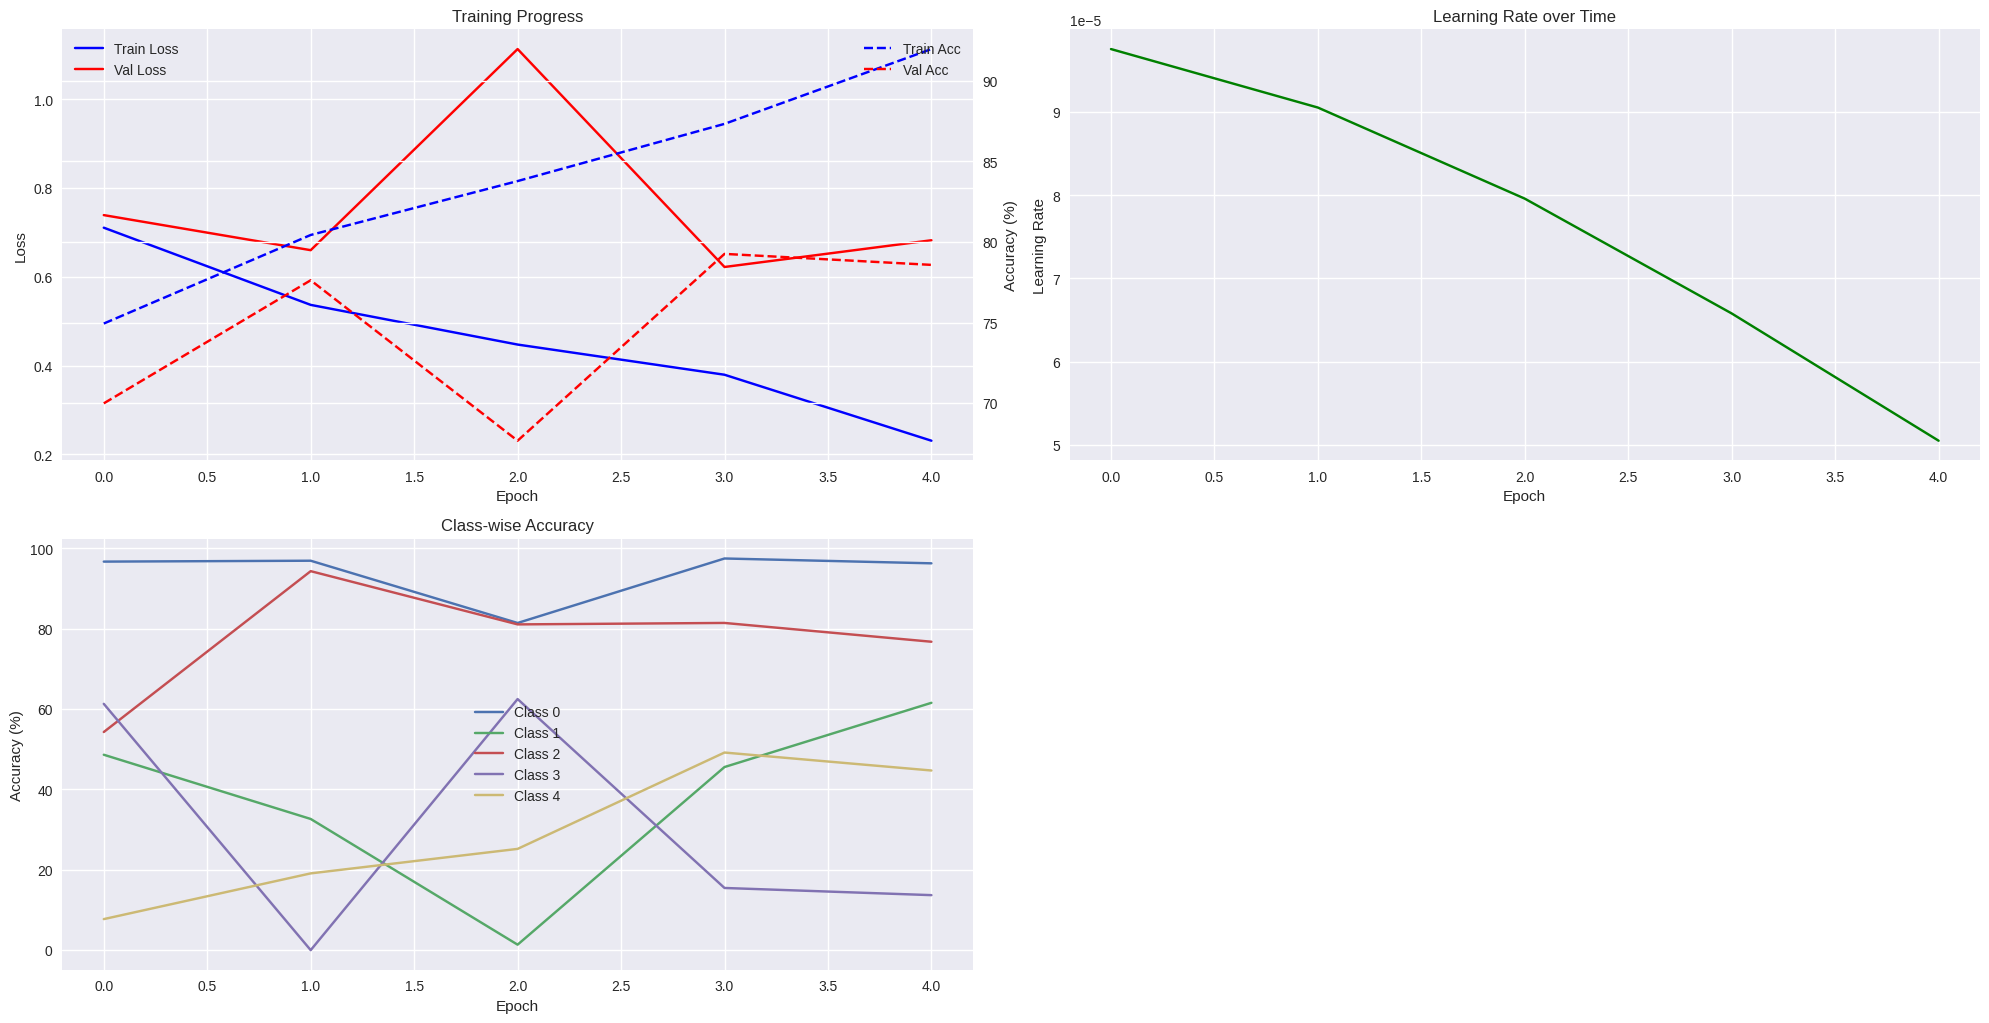

Epoch [5/25] - Train Loss: 0.2309, Train Acc: 91.98% | Val Loss: 0.6826, Val Acc: 78.58%


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.000145, acc=95.6]


New best model saved with validation accuracy: 81.72%
Epoch [6/25] - Train Loss: 0.1399, Train Acc: 95.60% | Val Loss: 0.7357, Val Acc: 81.72%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.28it/s, loss=0.0151, acc=97.7]  


New best model saved with validation accuracy: 81.86%
Epoch [7/25] - Train Loss: 0.0693, Train Acc: 97.68% | Val Loss: 0.7800, Val Acc: 81.86%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.00108, acc=98.3] 


Epoch [8/25] - Train Loss: 0.0369, Train Acc: 98.29% | Val Loss: 0.8856, Val Acc: 81.58%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=0.000156, acc=99]  


New best model saved with validation accuracy: 82.54%
Epoch [9/25] - Train Loss: 0.0224, Train Acc: 98.98% | Val Loss: 0.9040, Val Acc: 82.54%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=2.44e-5, acc=99]   
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


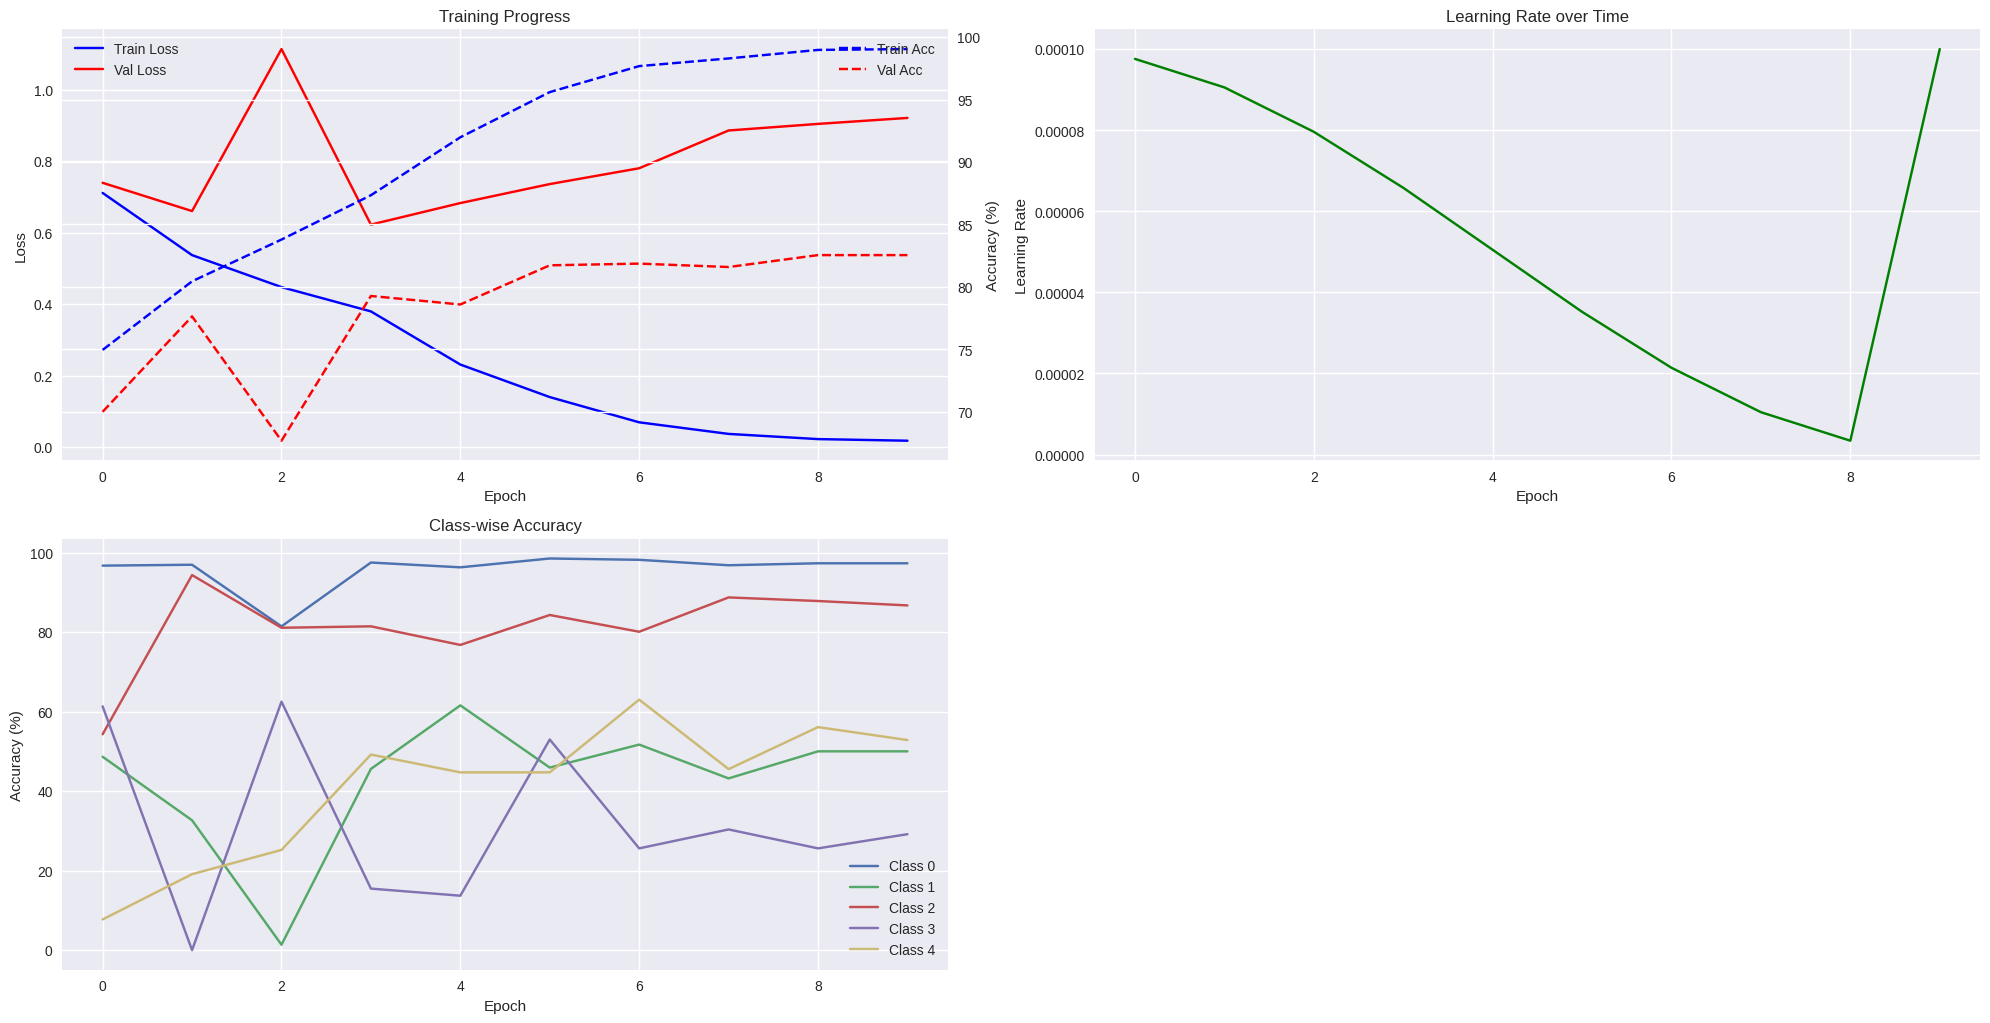

Epoch [10/25] - Train Loss: 0.0178, Train Acc: 99.04% | Val Loss: 0.9207, Val Acc: 82.54%


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=1.85, acc=87.1]    


Epoch [11/25] - Train Loss: 0.3555, Train Acc: 87.09% | Val Loss: 0.8600, Val Acc: 77.35%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.29it/s, loss=4.17, acc=89.1]    


Epoch [12/25] - Train Loss: 0.3070, Train Acc: 89.07% | Val Loss: 0.8146, Val Acc: 80.35%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.0068, acc=94.1]  


Epoch [13/25] - Train Loss: 0.1774, Train Acc: 94.06% | Val Loss: 0.8267, Val Acc: 78.58%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.0028, acc=94.8]  


Epoch [14/25] - Train Loss: 0.1530, Train Acc: 94.81% | Val Loss: 0.8928, Val Acc: 78.85%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.0201, acc=97.8]  
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


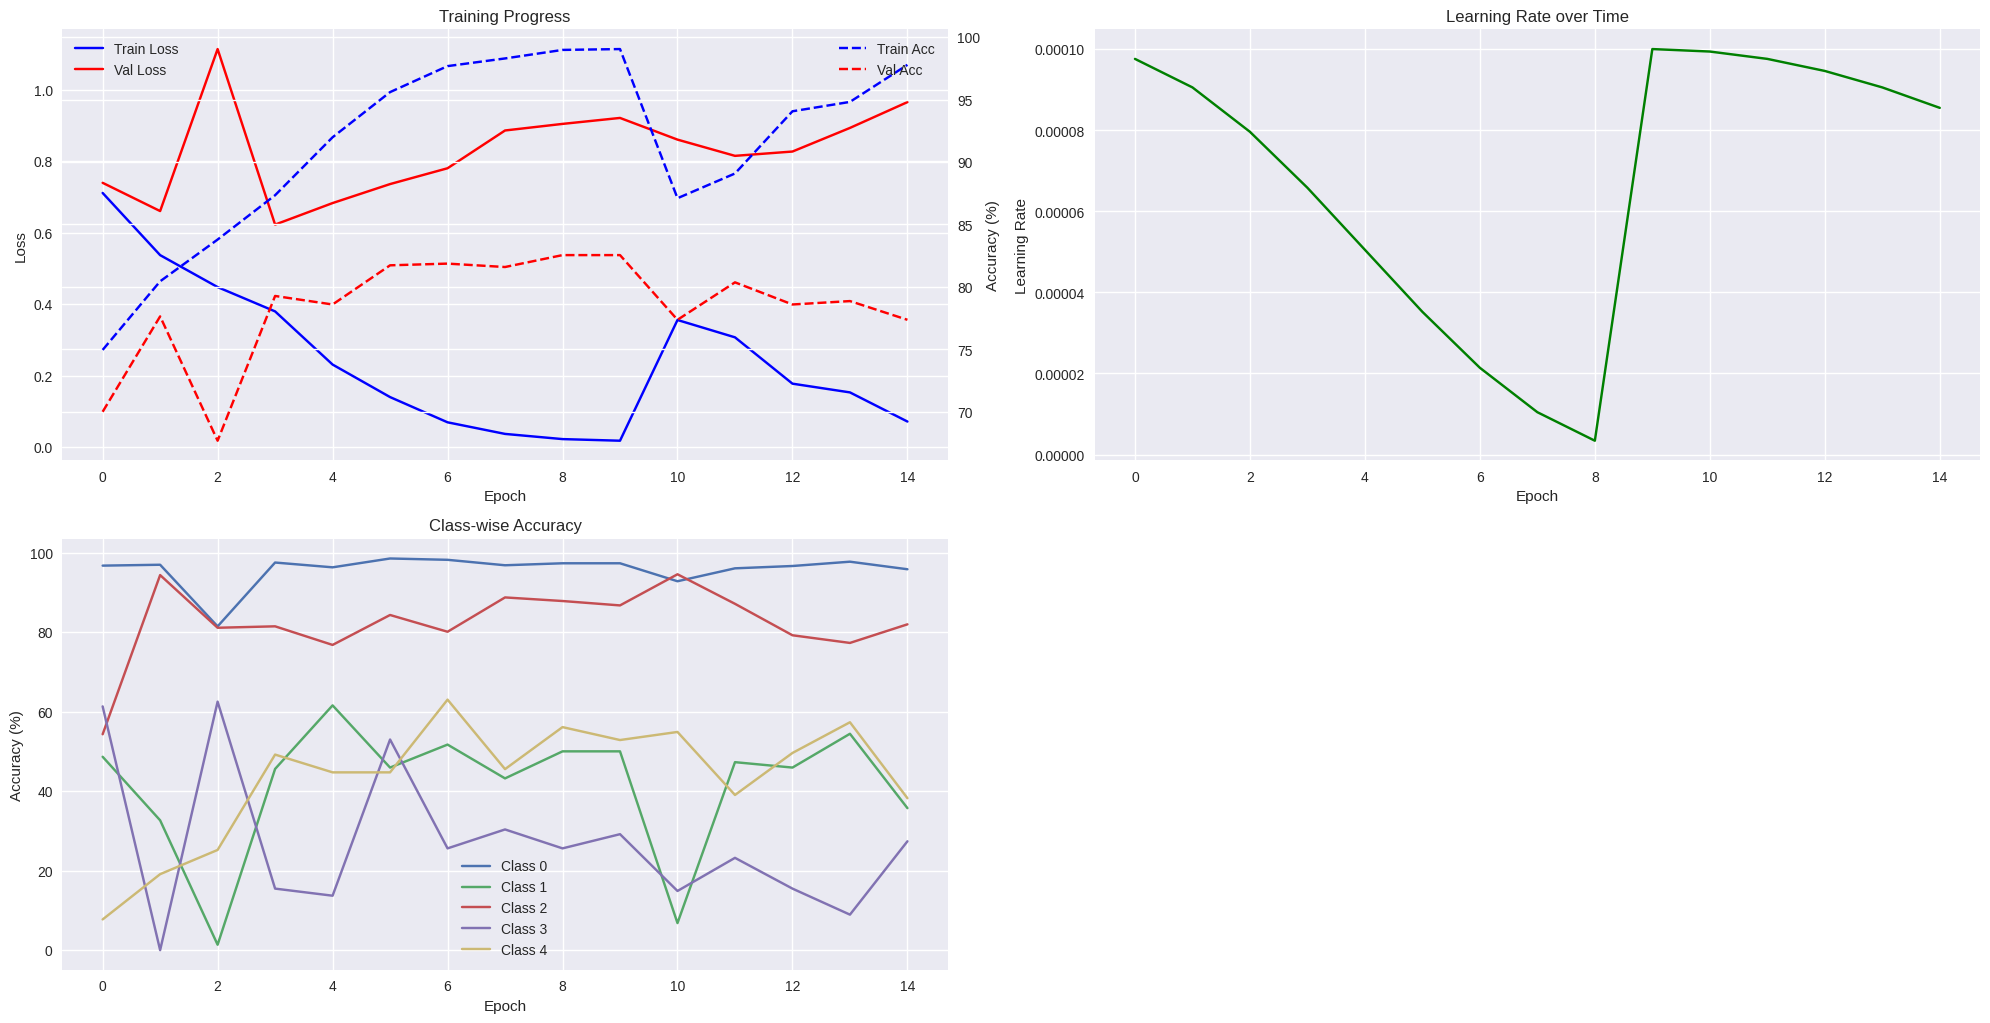

Epoch [15/25] - Train Loss: 0.0714, Train Acc: 97.78% | Val Loss: 0.9650, Val Acc: 77.35%


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.000349, acc=96.8]


Epoch [16/25] - Train Loss: 0.0898, Train Acc: 96.82% | Val Loss: 0.9072, Val Acc: 80.08%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.689, acc=98]     


Epoch [17/25] - Train Loss: 0.0548, Train Acc: 97.99% | Val Loss: 1.0549, Val Acc: 78.44%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.000149, acc=95.1]


Epoch [18/25] - Train Loss: 0.1453, Train Acc: 95.08% | Val Loss: 0.9919, Val Acc: 80.22%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=0.00126, acc=97]   


Epoch [19/25] - Train Loss: 0.0655, Train Acc: 97.00% | Val Loss: 1.0779, Val Acc: 78.72%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.00125, acc=98.3] 
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


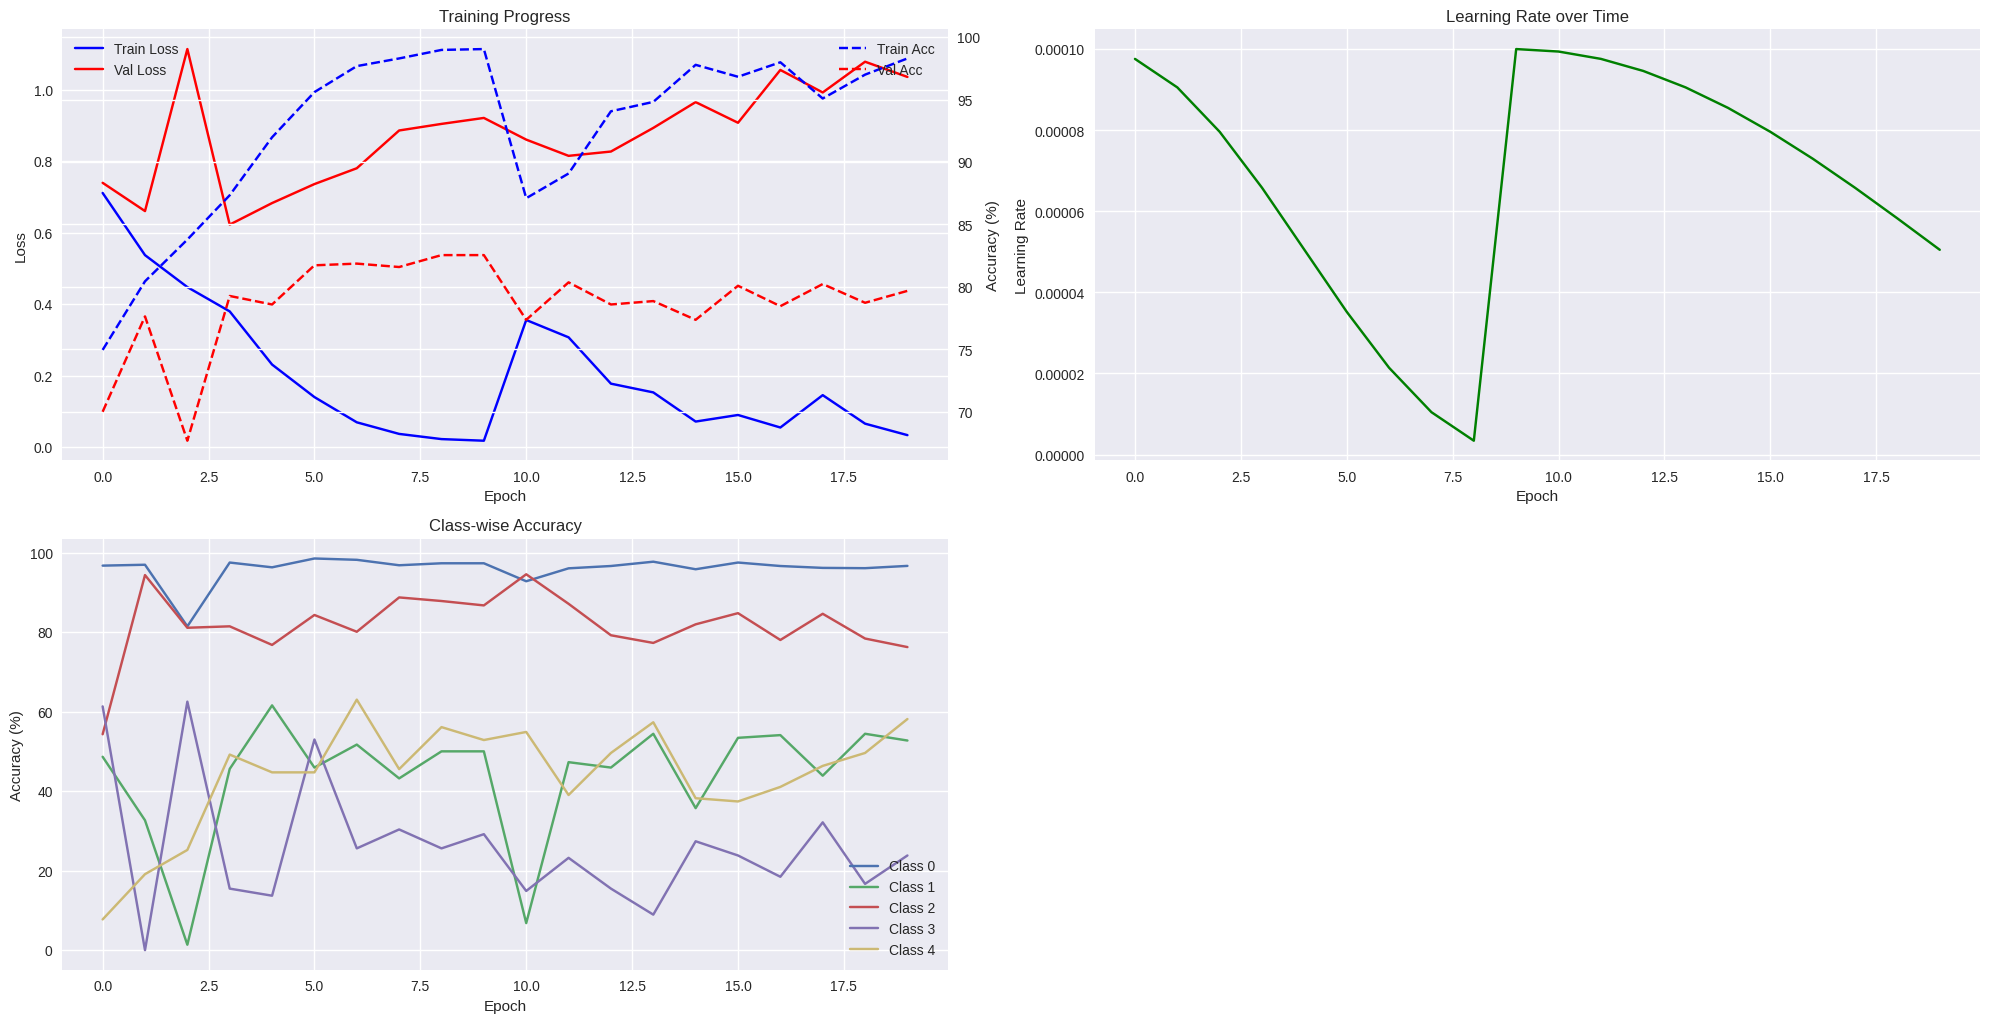

Epoch [20/25] - Train Loss: 0.0334, Train Acc: 98.29% | Val Loss: 1.0354, Val Acc: 79.67%


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=0.00109, acc=98.7] 


Epoch [21/25] - Train Loss: 0.0227, Train Acc: 98.74% | Val Loss: 1.1266, Val Acc: 81.17%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=4.37e-5, acc=98.7] 


Epoch [22/25] - Train Loss: 0.0199, Train Acc: 98.70% | Val Loss: 1.1795, Val Acc: 81.72%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=0.000418, acc=98.8]


Epoch [23/25] - Train Loss: 0.0180, Train Acc: 98.81% | Val Loss: 1.1841, Val Acc: 81.58%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=1.61e-5, acc=98.7] 


Epoch [24/25] - Train Loss: 0.0169, Train Acc: 98.70% | Val Loss: 1.2077, Val Acc: 81.45%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=5.48e-6, acc=98.8] 
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


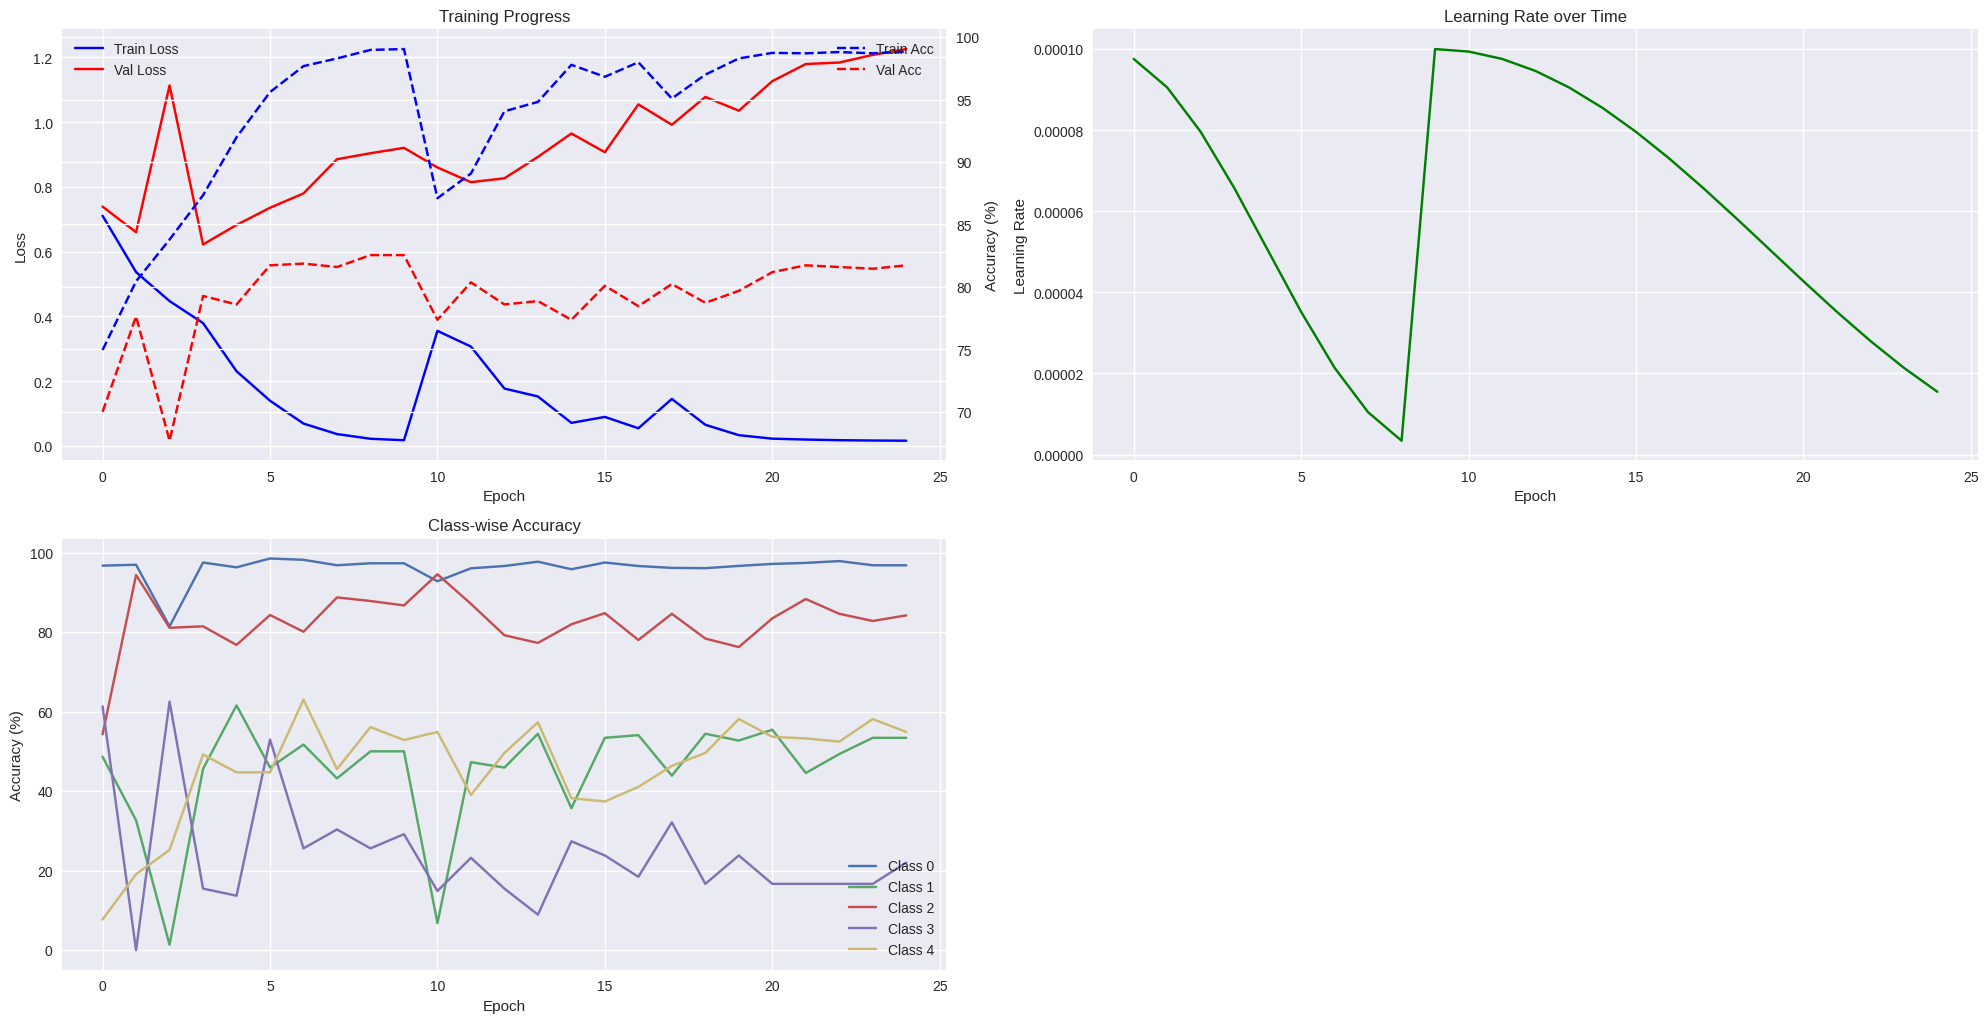

Epoch [25/25] - Train Loss: 0.0163, Train Acc: 98.84% | Val Loss: 1.2257, Val Acc: 81.72%


In [11]:
# Cell 10: Run Training
if __name__ == "__main__":
    main()

In [12]:
# Cell 11: Visualization Functions
def plot_confusion_matrix(true_labels, predictions, save_path='confusion_matrix.png'):
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curves(true_labels, probabilities):
    plt.figure(figsize=(12, 8))
    
    # One-hot encode true labels
    true_labels_onehot = np.eye(5)[true_labels]
    
    for i in range(5):
        fpr, tpr, _ = roc_curve(true_labels_onehot[:, i], probabilities[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend()
    plt.show()

def plot_training_history(metrics):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics.train_losses, label='Train Loss')
    plt.plot(metrics.val_losses, label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics.train_accuracies, label='Train Accuracy')
    plt.plot(metrics.val_accuracies, label='Val Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [13]:
# Cell 12: Model Evaluation Function
def evaluate_model(model, data_loader, criterion, device, phase='Validation', has_labels=True):
    model.eval()
    running_loss = 0.0
    predictions = []
    true_labels = [] if has_labels else None
    probabilities = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f'{phase} Evaluation'):
            if has_labels:
                images, labels = batch
                labels = labels.to(device)
            else:
                images = batch
            
            images = images.to(device)
            outputs = model(images)
            
            if has_labels:
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            if has_labels:
                true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    
    results = {
        'predictions': np.array(predictions),
        'probabilities': np.array(probabilities)
    }
    
    if has_labels:
        results.update({
            'loss': running_loss / len(data_loader),
            'accuracy': accuracy_score(true_labels, predictions) * 100,
            'true_labels': np.array(true_labels)
        })
    
    return results

In [14]:
# Cell 13: Load and Evaluate Best Model
def evaluate_best_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the best model
    model = ViTClassifier().to(device)
    model.load_state_dict(torch.load(Config.CHECKPOINT_DIR / 'best_model.pth'))
    criterion = nn.CrossEntropyLoss()
    
    # Load test data
    test_df = pd.read_csv(Config.TEST_CSV)
    has_labels = 'diagnosis' in test_df.columns
    test_loader = create_test_loader(test_df, Config.TEST_PATH, has_labels=has_labels)
    
    # Evaluate
    results = evaluate_model(model, test_loader, criterion, device, 
                           phase='Test', has_labels=has_labels)
    
    if has_labels:
        # Plot confusion matrix
        plot_confusion_matrix(results['true_labels'], results['predictions'])
        
        # Plot ROC curves
        plot_roc_curves(results['true_labels'], results['probabilities'])
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(results['true_labels'], results['predictions']))
        
        print(f"\nTest Accuracy: {results['accuracy']:.2f}%")
    else:
        print("Predictions saved for unlabeled test set")
        np.save('test_predictions.npy', results['predictions'])
    
    return results


Using device: cuda


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch32-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-acb2c37145a4>:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:41<00:00,  2.27it/s, loss=0.671, acc=72.9]  


New best model saved with validation accuracy: 76.94%
Epoch [1/25] - Train Loss: 0.7316, Train Acc: 72.86% | Val Loss: 0.6675, Val Acc: 76.94%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.29it/s, loss=0.337, acc=79.8] 


New best model saved with validation accuracy: 78.44%
Epoch [2/25] - Train Loss: 0.5596, Train Acc: 79.75% | Val Loss: 0.6061, Val Acc: 78.44%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=0.00316, acc=83.3]


New best model saved with validation accuracy: 78.72%
Epoch [3/25] - Train Loss: 0.4598, Train Acc: 83.30% | Val Loss: 0.6245, Val Acc: 78.72%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.0712, acc=87.4] 


Epoch [4/25] - Train Loss: 0.3524, Train Acc: 87.40% | Val Loss: 0.7109, Val Acc: 76.40%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.00142, acc=92.1]
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


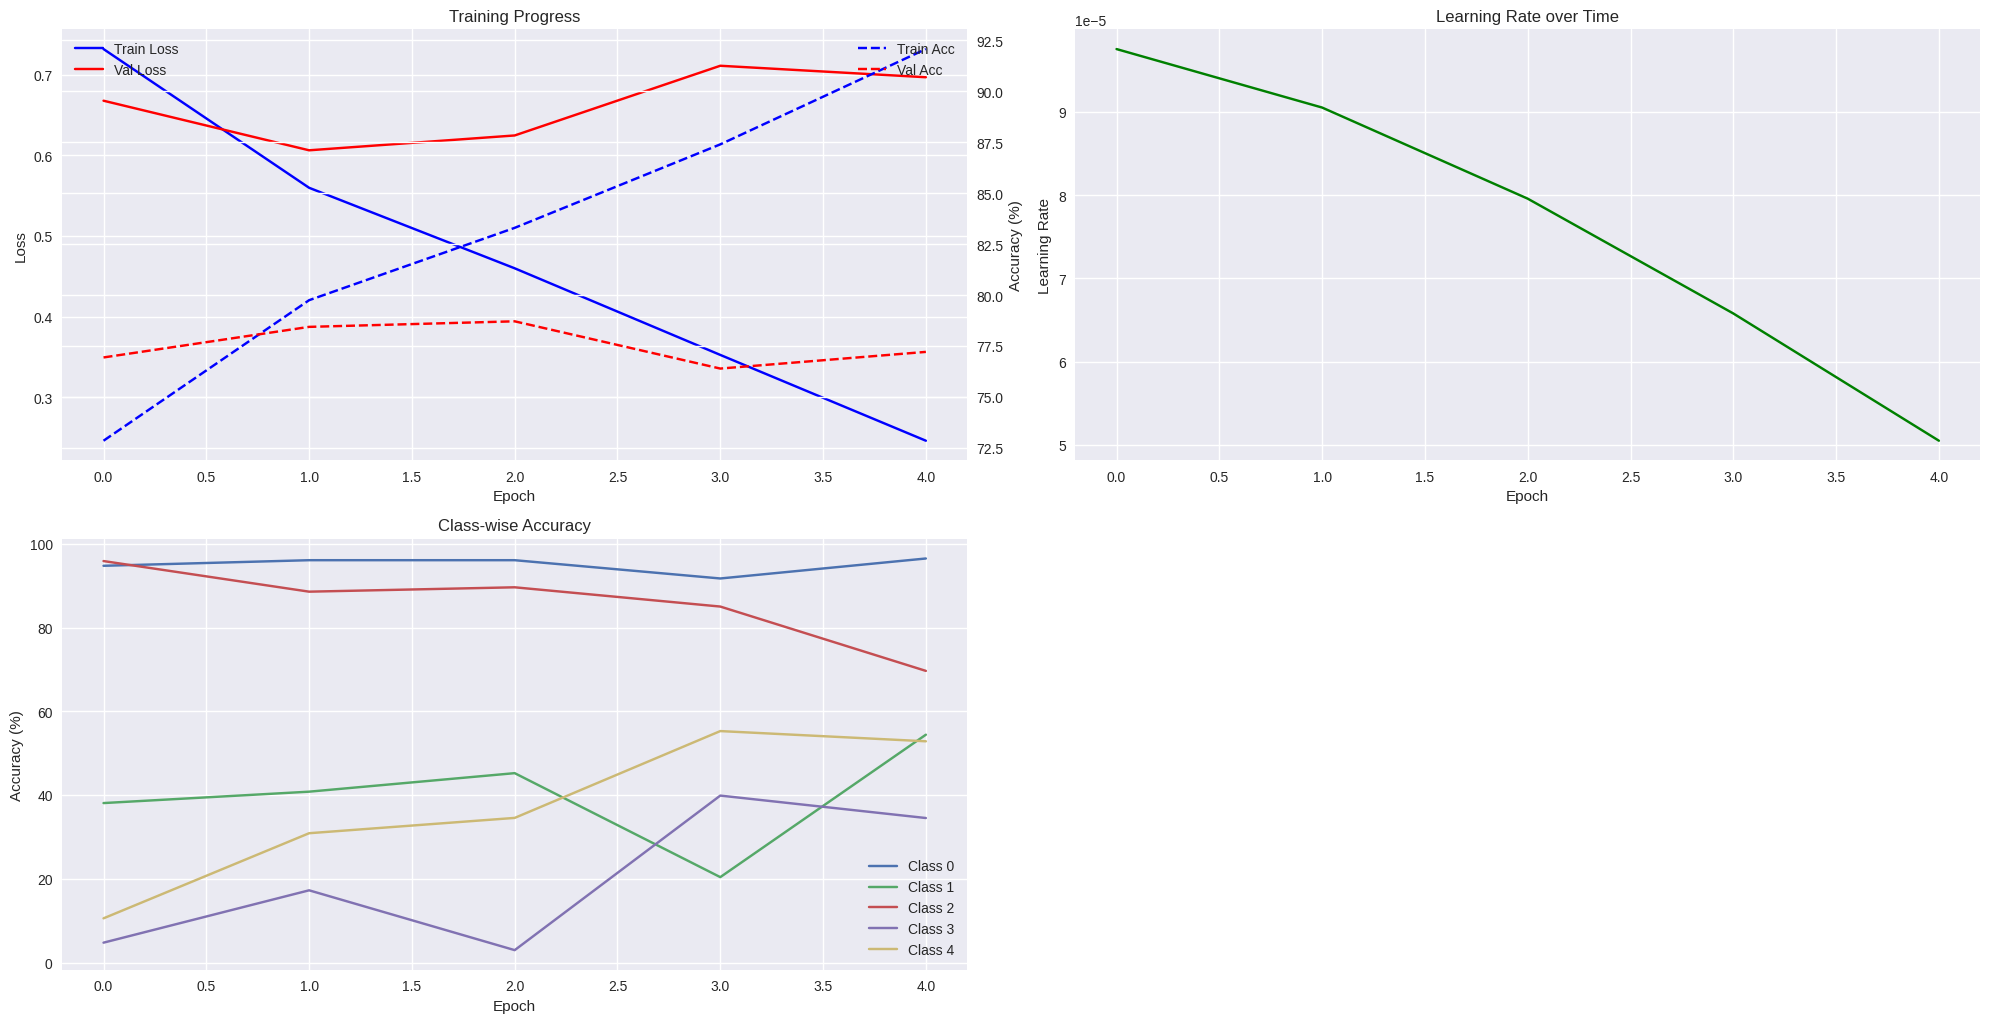

Epoch [5/25] - Train Loss: 0.2461, Train Acc: 92.08% | Val Loss: 0.6966, Val Acc: 77.22%


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.803, acc=95.2]   


New best model saved with validation accuracy: 79.40%
Epoch [6/25] - Train Loss: 0.1422, Train Acc: 95.22% | Val Loss: 0.7418, Val Acc: 79.40%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.28it/s, loss=0.00321, acc=97.5] 


New best model saved with validation accuracy: 80.76%
Epoch [7/25] - Train Loss: 0.0738, Train Acc: 97.47% | Val Loss: 0.9024, Val Acc: 80.76%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.000361, acc=98.4]


Epoch [8/25] - Train Loss: 0.0372, Train Acc: 98.36% | Val Loss: 0.9193, Val Acc: 80.35%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.29it/s, loss=9.18e-5, acc=98.9] 


Epoch [9/25] - Train Loss: 0.0224, Train Acc: 98.87% | Val Loss: 0.9273, Val Acc: 80.63%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=0.00208, acc=99]   
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


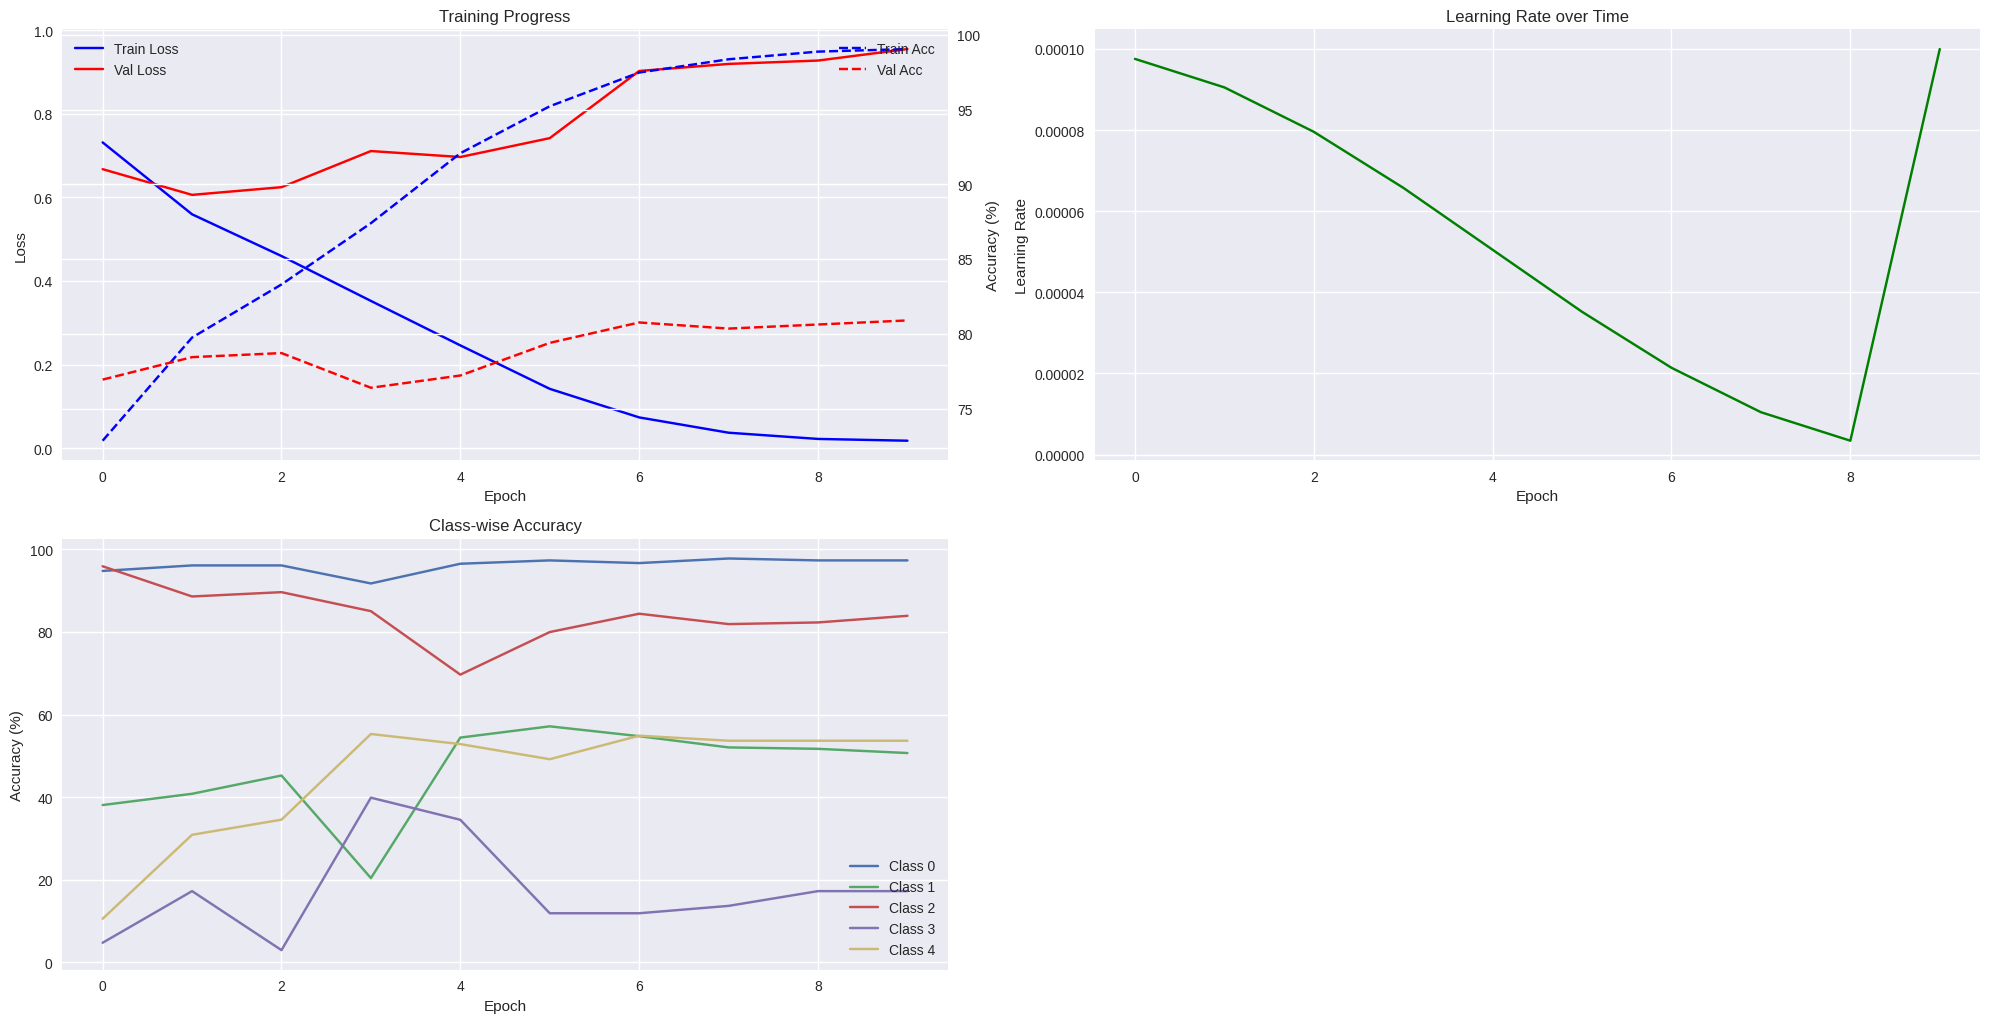

New best model saved with validation accuracy: 80.90%
Epoch [10/25] - Train Loss: 0.0181, Train Acc: 99.04% | Val Loss: 0.9548, Val Acc: 80.90%


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.00713, acc=88.9] 


Epoch [11/25] - Train Loss: 0.2947, Train Acc: 88.94% | Val Loss: 0.6480, Val Acc: 78.17%


Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=0.00455, acc=88.3]


Epoch [12/25] - Train Loss: 0.3368, Train Acc: 88.29% | Val Loss: 0.7163, Val Acc: 77.63%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.000259, acc=92.8]


Epoch [13/25] - Train Loss: 0.2037, Train Acc: 92.83% | Val Loss: 0.9008, Val Acc: 76.53%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.28it/s, loss=0.0289, acc=93.8]  


Epoch [14/25] - Train Loss: 0.1745, Train Acc: 93.79% | Val Loss: 0.8888, Val Acc: 79.54%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.0529, acc=96.3]  
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


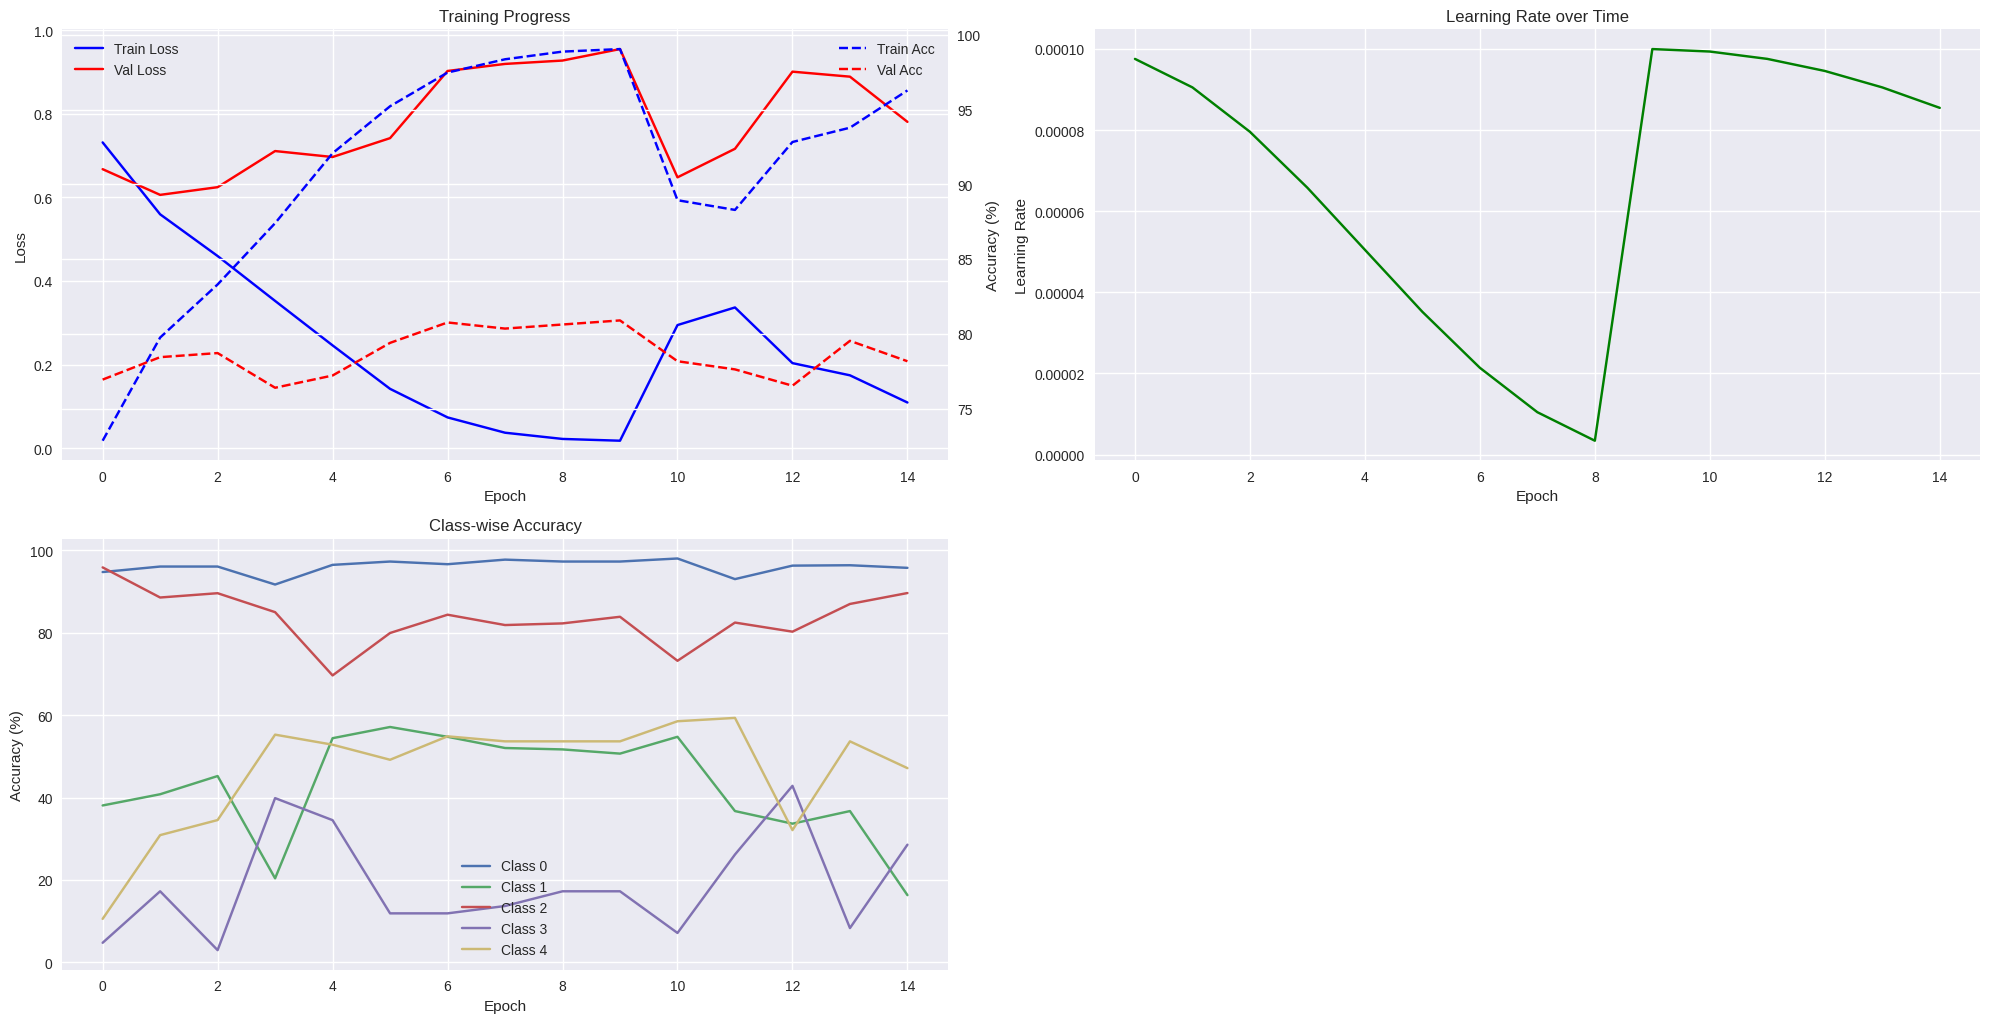

Epoch [15/25] - Train Loss: 0.1095, Train Acc: 96.28% | Val Loss: 0.7807, Val Acc: 78.17%


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:39<00:00,  2.29it/s, loss=0.00285, acc=97.3] 


Epoch [16/25] - Train Loss: 0.0820, Train Acc: 97.34% | Val Loss: 0.9717, Val Acc: 78.44%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.000469, acc=97.9]


Epoch [17/25] - Train Loss: 0.0543, Train Acc: 97.92% | Val Loss: 0.9603, Val Acc: 78.31%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.000164, acc=97.9]


Epoch [18/25] - Train Loss: 0.0525, Train Acc: 97.88% | Val Loss: 1.0767, Val Acc: 77.76%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.00586, acc=98.4] 


Epoch [19/25] - Train Loss: 0.0353, Train Acc: 98.40% | Val Loss: 1.1823, Val Acc: 79.67%


Training: 100%|██████████| 367/367 [02:41<00:00,  2.28it/s, loss=3.71e-5, acc=98.2] 
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


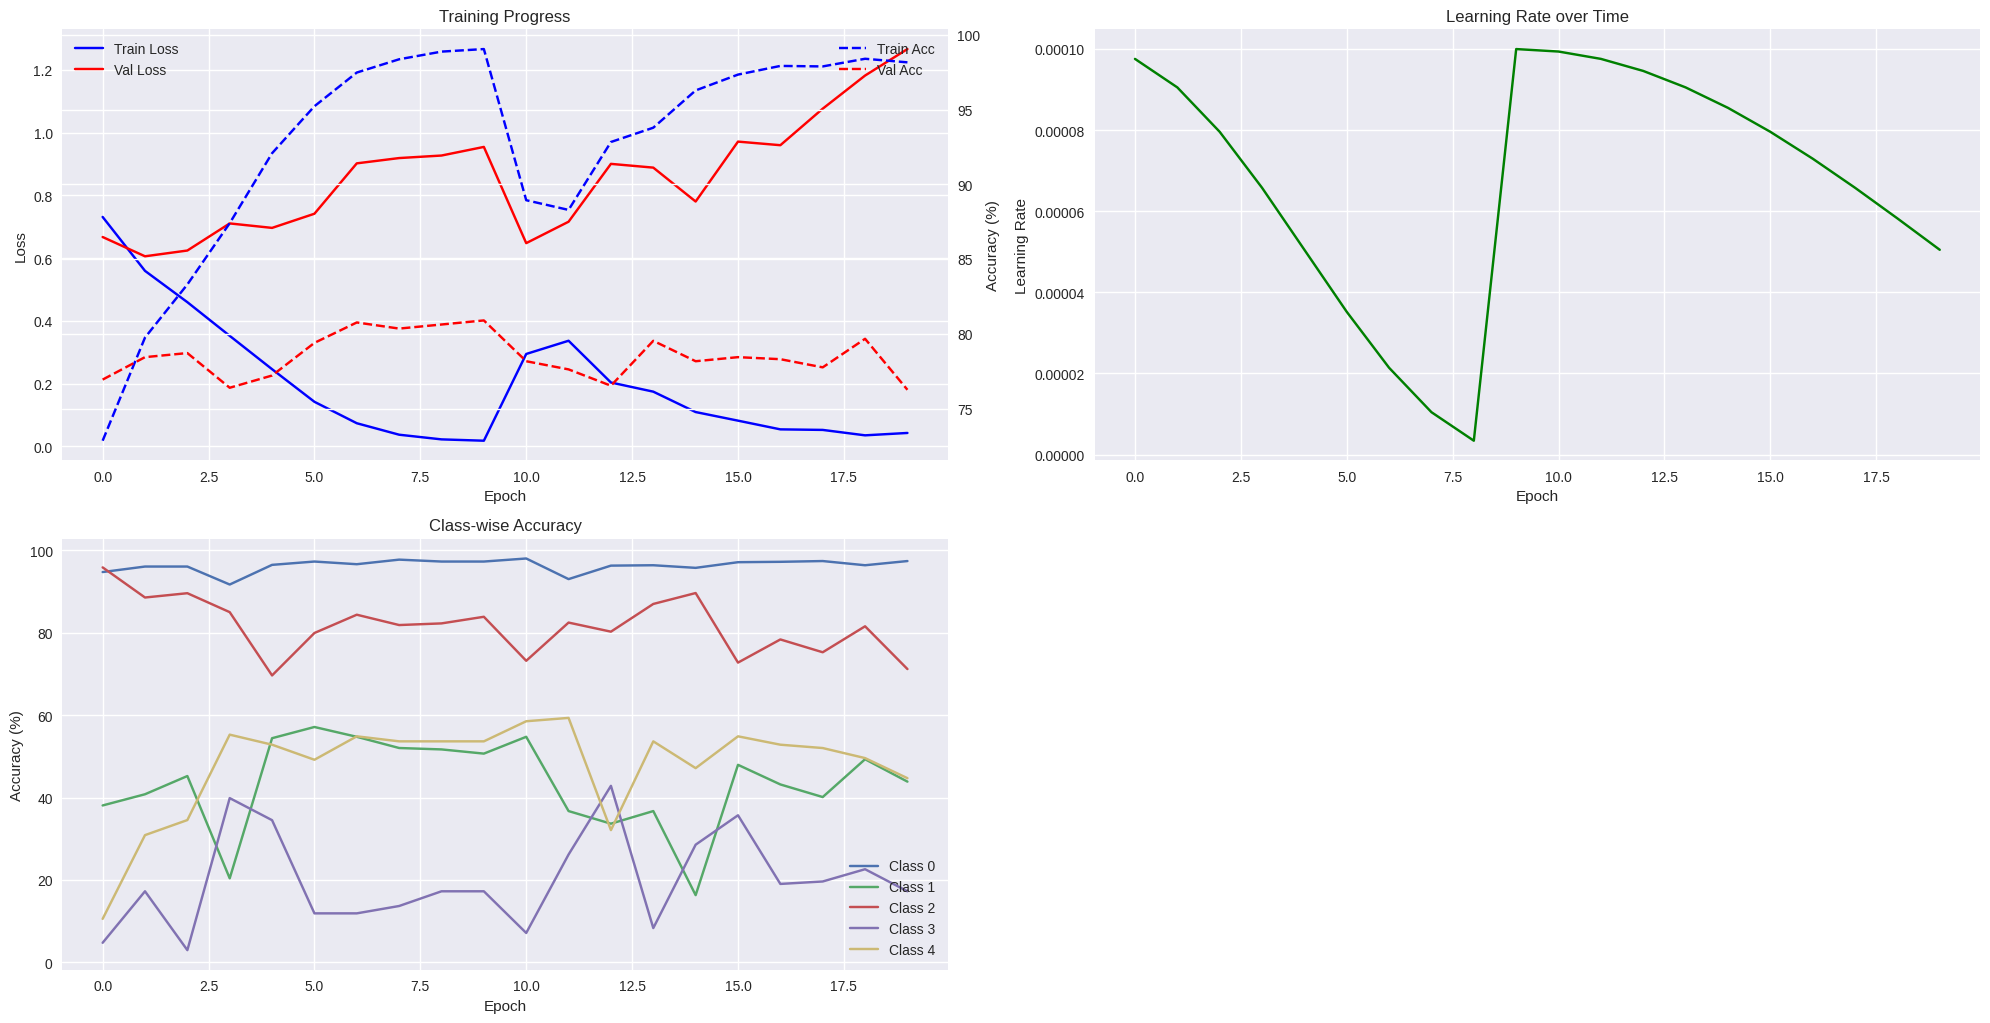

Epoch [20/25] - Train Loss: 0.0428, Train Acc: 98.16% | Val Loss: 1.2668, Val Acc: 76.26%


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:40<00:00,  2.28it/s, loss=3.17e-5, acc=98.1] 


Epoch [21/25] - Train Loss: 0.0442, Train Acc: 98.12% | Val Loss: 1.2890, Val Acc: 77.35%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.28it/s, loss=0.000192, acc=98.2]


Epoch [22/25] - Train Loss: 0.0390, Train Acc: 98.22% | Val Loss: 1.2687, Val Acc: 78.58%


Training: 100%|██████████| 367/367 [02:41<00:00,  2.28it/s, loss=0.000356, acc=98.6]


Epoch [23/25] - Train Loss: 0.0184, Train Acc: 98.63% | Val Loss: 1.2649, Val Acc: 79.81%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.28it/s, loss=0.000596, acc=98.8]


Epoch [24/25] - Train Loss: 0.0166, Train Acc: 98.81% | Val Loss: 1.2963, Val Acc: 78.85%


Training: 100%|██████████| 367/367 [02:40<00:00,  2.28it/s, loss=7.5e-5, acc=98.7]  
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


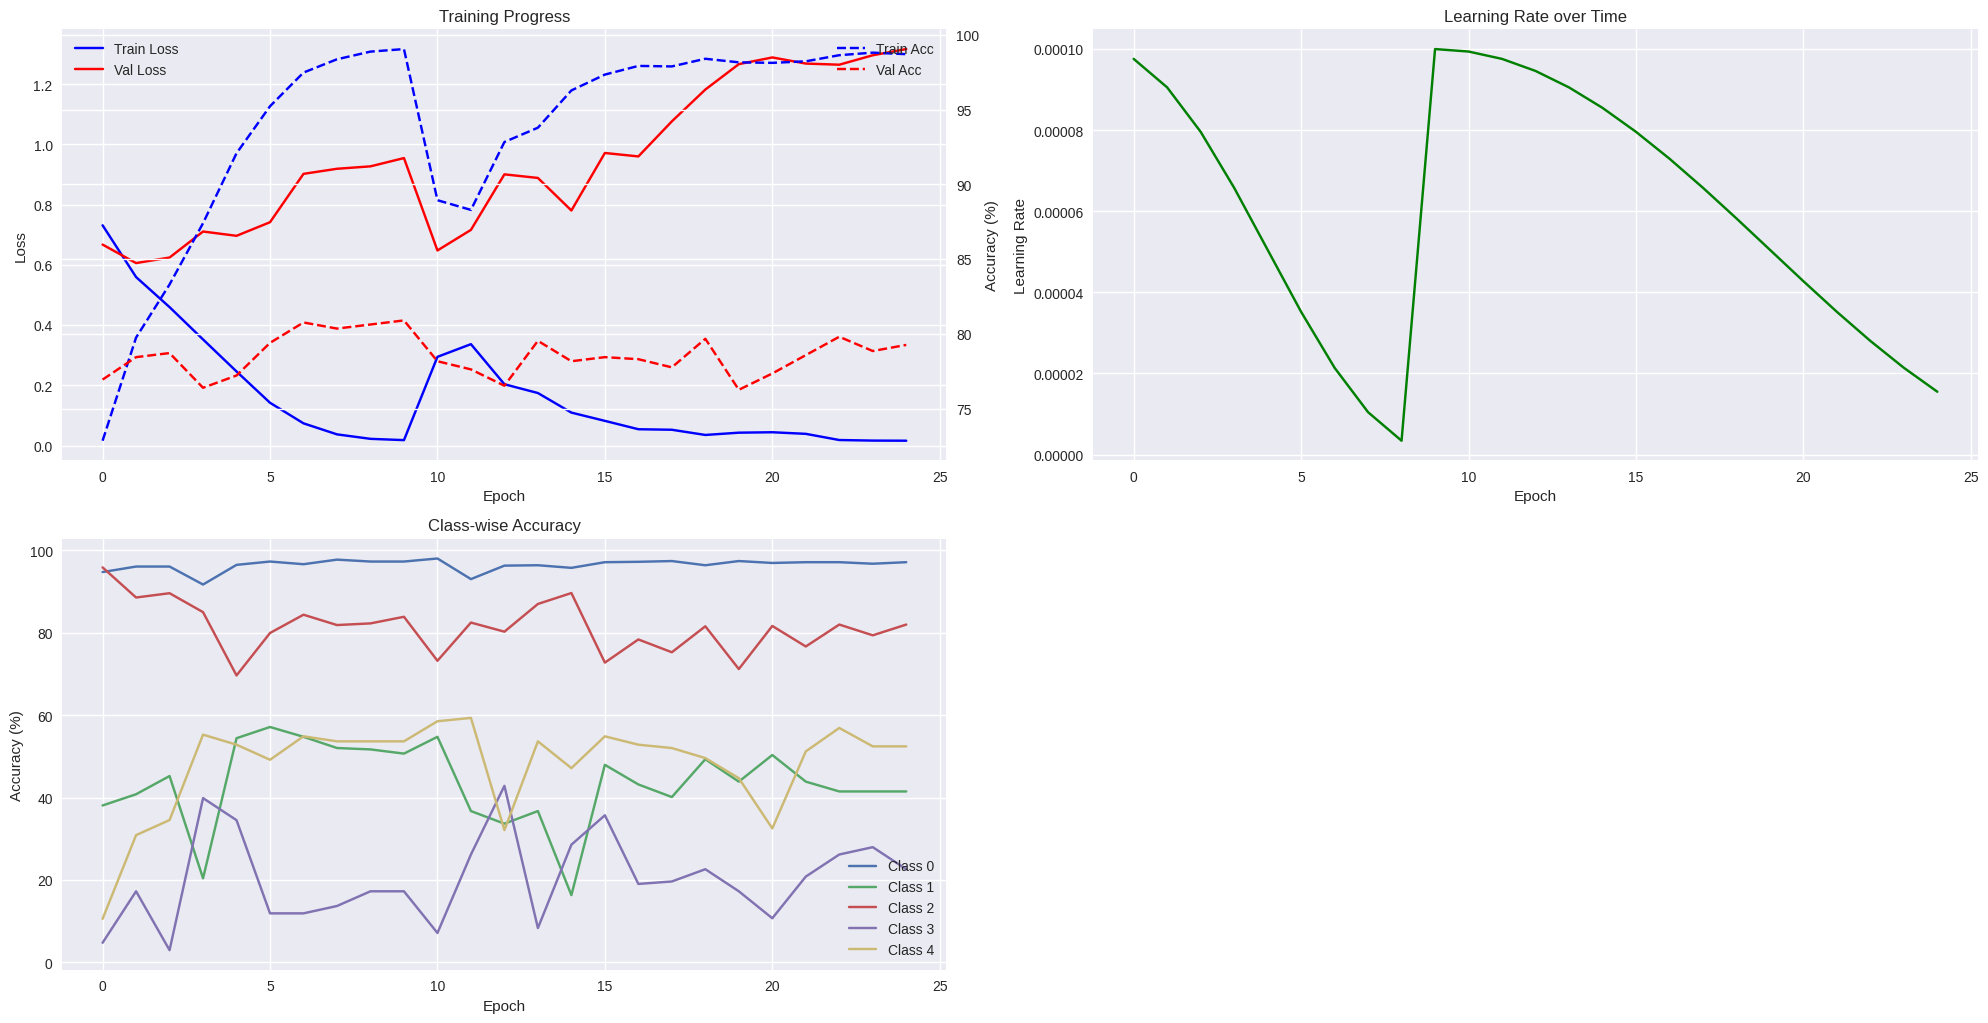

Epoch [25/25] - Train Loss: 0.0161, Train Acc: 98.70% | Val Loss: 1.3168, Val Acc: 79.26%


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch32-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-349a039cd31b>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

Predictions saved for unlabeled test set


In [15]:
# Cell 14: Example Usage
if __name__ == "__main__":
    # First run the training
    main()
    
    # Then evaluate the best model
    results = evaluate_best_model()


In [16]:
# Cell 15: Fine-tuning (Optional)
def fine_tune_model(model, train_loader, valid_loader, criterion, device):
    """
    Fine-tune the model with gradual unfreezing
    """
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze classifier
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    optimizer = optim.AdamW([
        {'params': model.classifier.parameters(), 'lr': Config.FINETUNE_LR}
    ])
    
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-6
    )
    
    scaler = torch.cuda.amp.GradScaler()
    metrics = MetricTracker()
    
    # First phase: train only classifier
    print("Phase 1: Training classifier...")
    for epoch in range(Config.FINETUNE_EPOCHS // 2):
        train_loss, train_acc, _ = train_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )
        val_loss, val_acc, _ = validate(
            model, valid_loader, criterion, device
        )
        
        metrics.update(train_loss, train_acc, val_loss, val_acc, 
                      0, optimizer.param_groups[0]['lr'])
        
        scheduler.step()
        
        if (epoch + 1) % 5 == 0:
            metrics.plot_detailed_metrics()
    
    # Second phase: unfreeze and train last few transformer layers
    print("\nPhase 2: Fine-tuning transformer layers...")
    for param in model.vit.encoder.layer[-4:].parameters():
        param.requires_grad = True
    
    optimizer = optim.AdamW([
        {'params': model.classifier.parameters(), 'lr': Config.FINETUNE_LR},
        {'params': model.vit.parameters(), 'lr': Config.FINETUNE_LR / 10}
    ])
    
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-7
    )
    
    for epoch in range(Config.FINETUNE_EPOCHS // 2):
        train_loss, train_acc, _ = train_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )
        val_loss, val_acc, _ = validate(
            model, valid_loader, criterion, device
        )
        
        metrics.update(train_loss, train_acc, val_loss, val_acc, 
                      0, optimizer.param_groups[0]['lr'])
        
        scheduler.step()
        
        if (epoch + 1) % 5 == 0:
            metrics.plot_detailed_metrics()
    
    return model, metrics
    

In [17]:
# Cell 16: Load and Prepare Sample Data
def load_sample_data():
    """
    Load and prepare a small sample of data for testing
    """
    print("Loading data...")
    
    # Load CSV files
    train_df = pd.read_csv(Config.TRAIN_CSV)
    test_df = pd.read_csv(Config.TEST_CSV)
    
    # Display sample information
    print("\nTraining Data Shape:", train_df.shape)
    print("Test Data Shape:", test_df.shape)
    
    # Display class distribution if labels exist
    if 'diagnosis' in train_df.columns:
        print("\nClass Distribution in Training Data:")
        print(train_df['diagnosis'].value_counts().sort_index())
        
        # Plot class distribution
        plt.figure(figsize=(10, 5))
        train_df['diagnosis'].value_counts().sort_index().plot(kind='bar')
        plt.title('Class Distribution in Training Data')
        plt.xlabel('DR Grade')
        plt.ylabel('Number of Images')
        plt.show()
    
    return train_df, test_df


In [18]:
# Cell 17: Display Sample Images
def display_sample_images(train_df, img_dir, num_samples=5):
    """
    Display sample images from each class
    """
    plt.figure(figsize=(15, 3))
    
    for i in range(num_samples):
        sample = train_df.iloc[i]
        img_path = os.path.join(img_dir, f"{sample.iloc[0]}.png")
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f'Grade: {sample.iloc[1]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [19]:
# Cell 18: Training Example
def run_training_example():
    """
    Run a complete training example
    """
    # Load data
    train_df, test_df = load_sample_data()
    
    # Create data loaders
    train_loader, valid_loader = create_data_loaders(train_df, Config.TRAIN_PATH)
    
    # Initialize model and components
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    scaler = torch.cuda.amp.GradScaler()
    
    # Train for a few epochs as example
    num_epochs = 3  # Reduced for demonstration
    metrics = MetricTracker()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        train_loss, train_acc, train_class_acc = train_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )
        
        # Validation phase
        val_loss, val_acc, val_class_acc = validate(
            model, valid_loader, criterion, device
        )
        
        # Update metrics
        metrics.update(
            train_loss, train_acc, val_loss, val_acc,
            0, optimizer.param_groups[0]['lr'],
            val_class_acc
        )
        
        # Plot current metrics
        metrics.plot_detailed_metrics()
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


In [20]:
# Cell 19: Evaluation Example
def run_evaluation_example():
    """
    Run evaluation on trained model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load the model
    model = ViTClassifier().to(device)
    try:
        model.load_state_dict(torch.load(Config.CHECKPOINT_DIR / 'best_model.pth'))
        print("Loaded best model successfully")
    except:
        print("No saved model found. Please train the model first.")
        return
    
    # Load test data
    test_df = pd.read_csv(Config.TEST_CSV)
    test_loader = create_test_loader(test_df, Config.TEST_PATH, 
                                   has_labels='diagnosis' in test_df.columns)
    
    # Evaluate
    results = evaluate_model(model, test_loader, nn.CrossEntropyLoss(), device, 
                           phase='Test', has_labels='diagnosis' in test_df.columns)
    
    return results

Loading data...

Training Data Shape: (3662, 2)
Test Data Shape: (1928, 1)

Class Distribution in Training Data:
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64


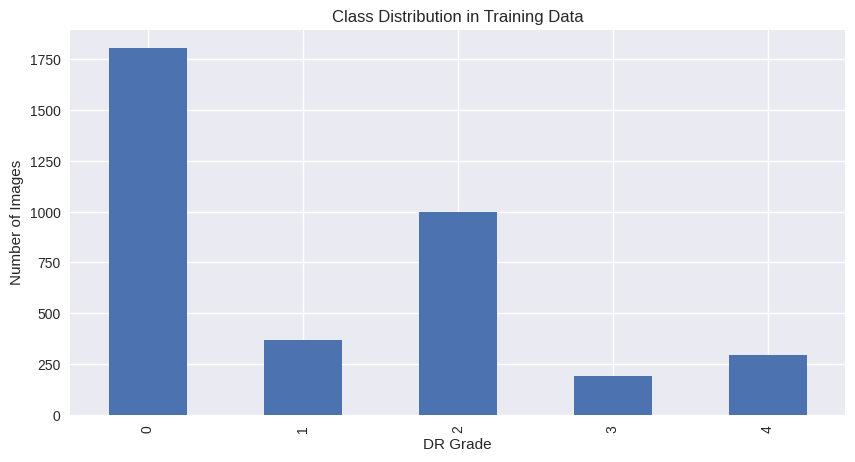

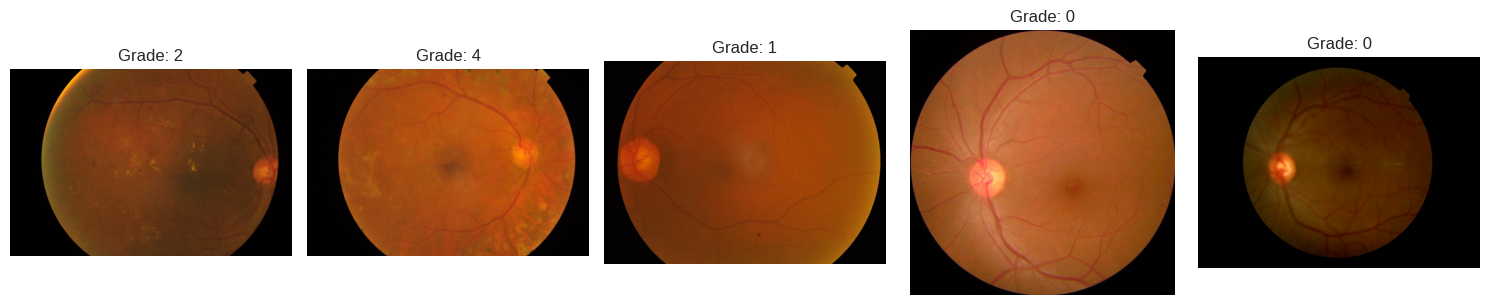

Loading data...

Training Data Shape: (3662, 2)
Test Data Shape: (1928, 1)

Class Distribution in Training Data:
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64


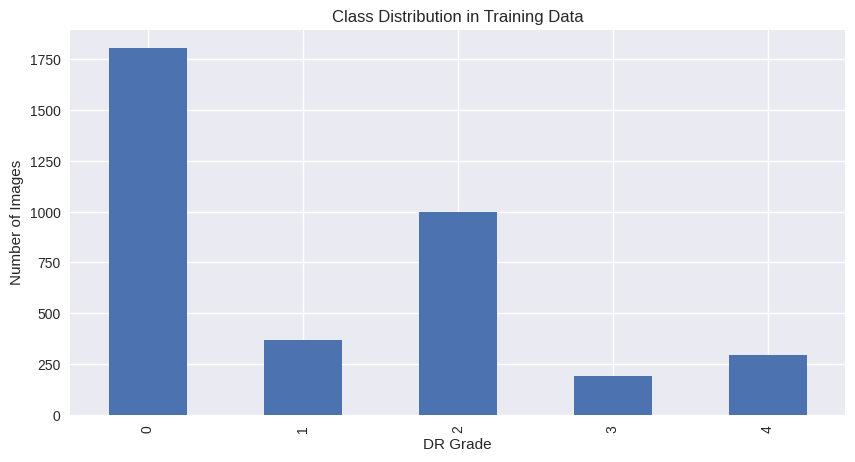

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch32-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-19-4b75112de199>:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/3


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:40<00:00,  2.29it/s, loss=0.32, acc=74.1]  
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


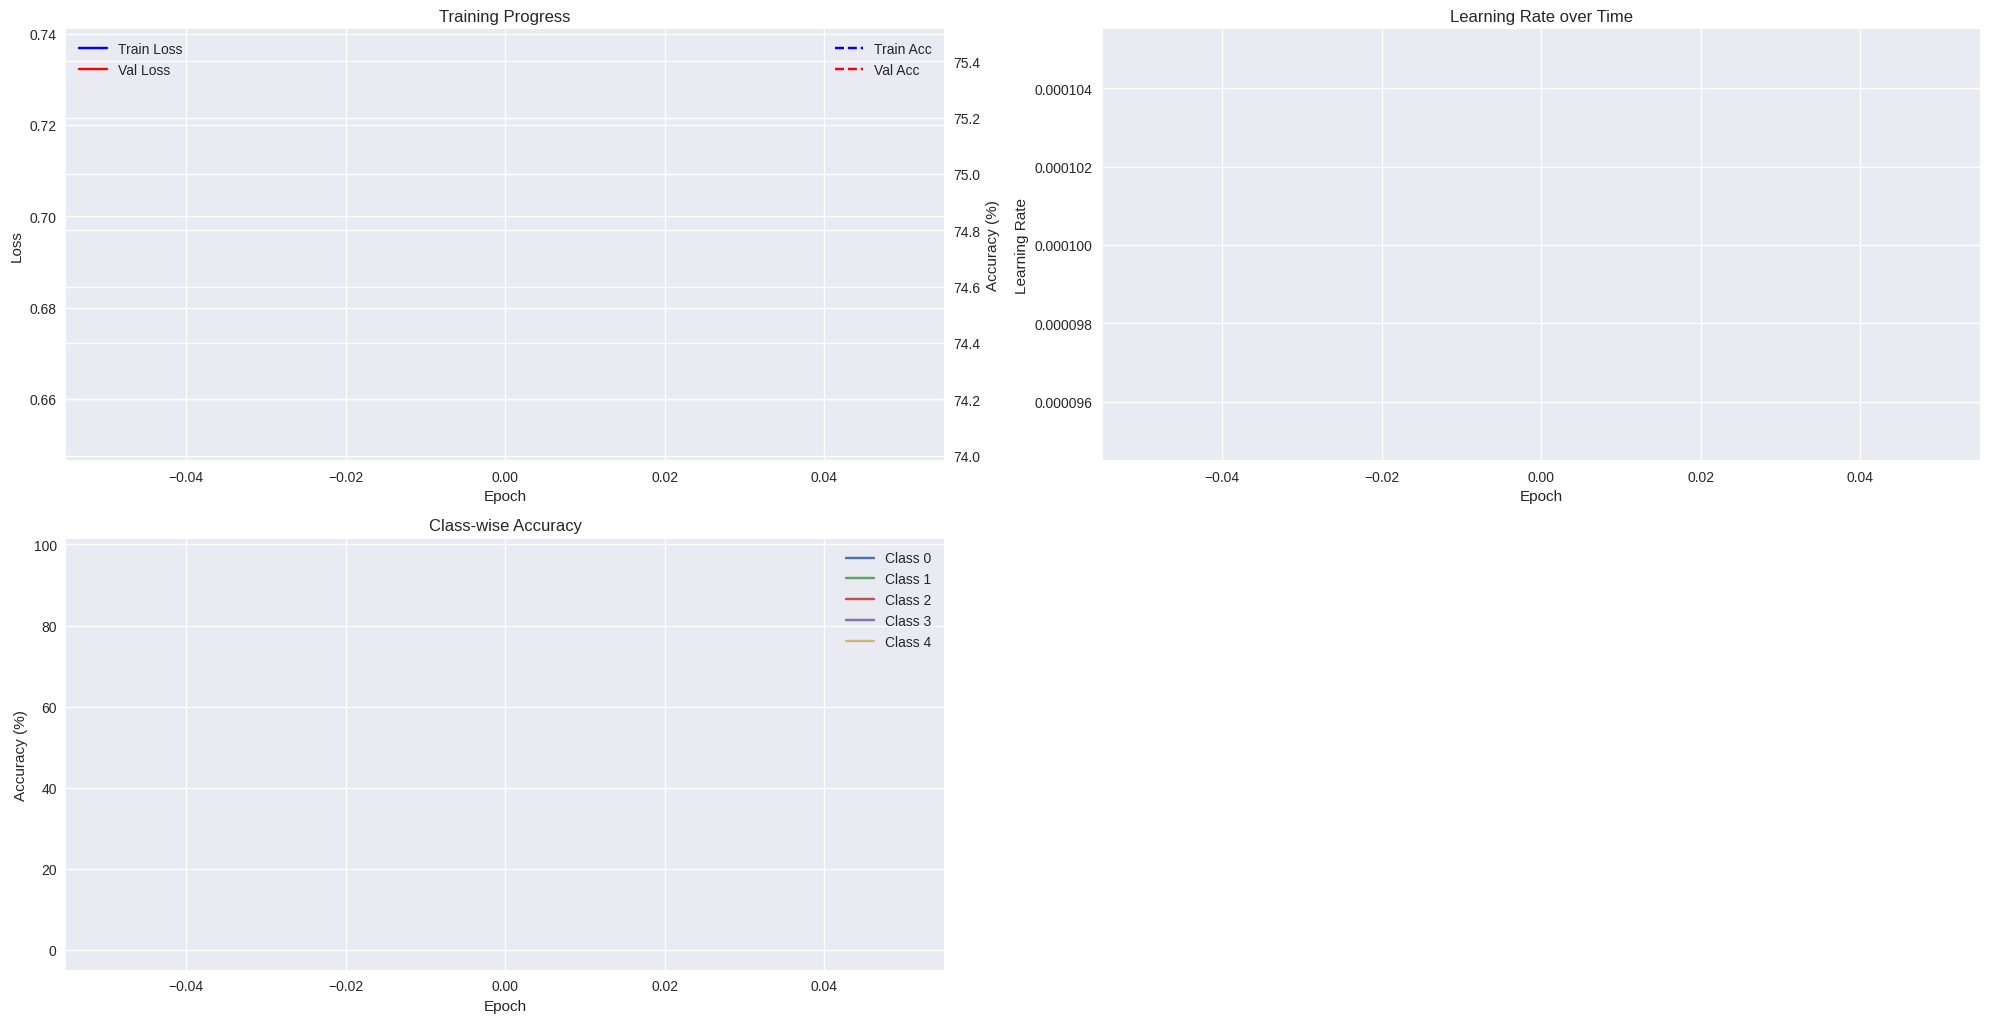

Train Loss: 0.7367, Train Acc: 74.05%
Val Loss: 0.6508, Val Acc: 75.44%

Epoch 2/3


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:40<00:00,  2.28it/s, loss=0.244, acc=79.3]  
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


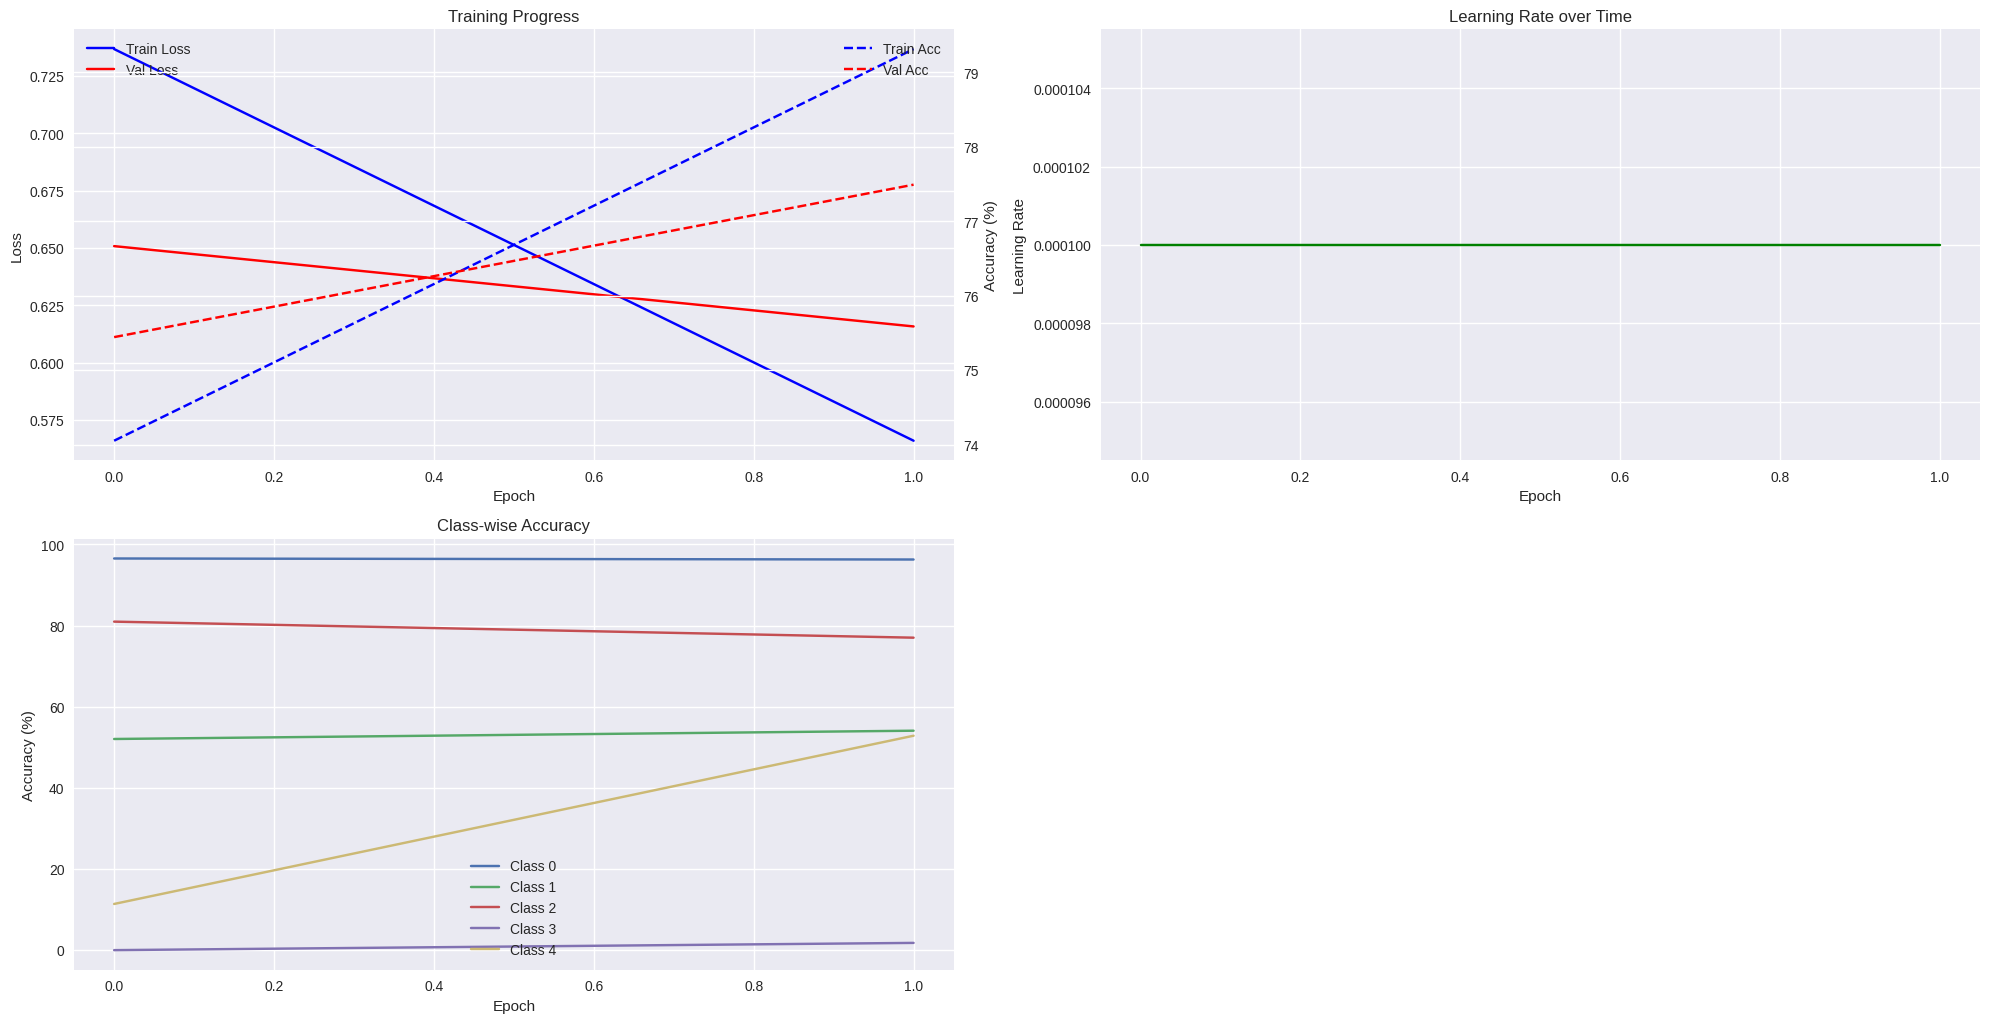

Train Loss: 0.5660, Train Acc: 79.31%
Val Loss: 0.6158, Val Acc: 77.49%

Epoch 3/3


Training:   0%|          | 0/367 [00:00<?, ?it/s]<ipython-input-9-dfd94f5d6dce>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 367/367 [02:39<00:00,  2.30it/s, loss=2.02, acc=81.9]  
<ipython-input-4-e9284e68b9e5>:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


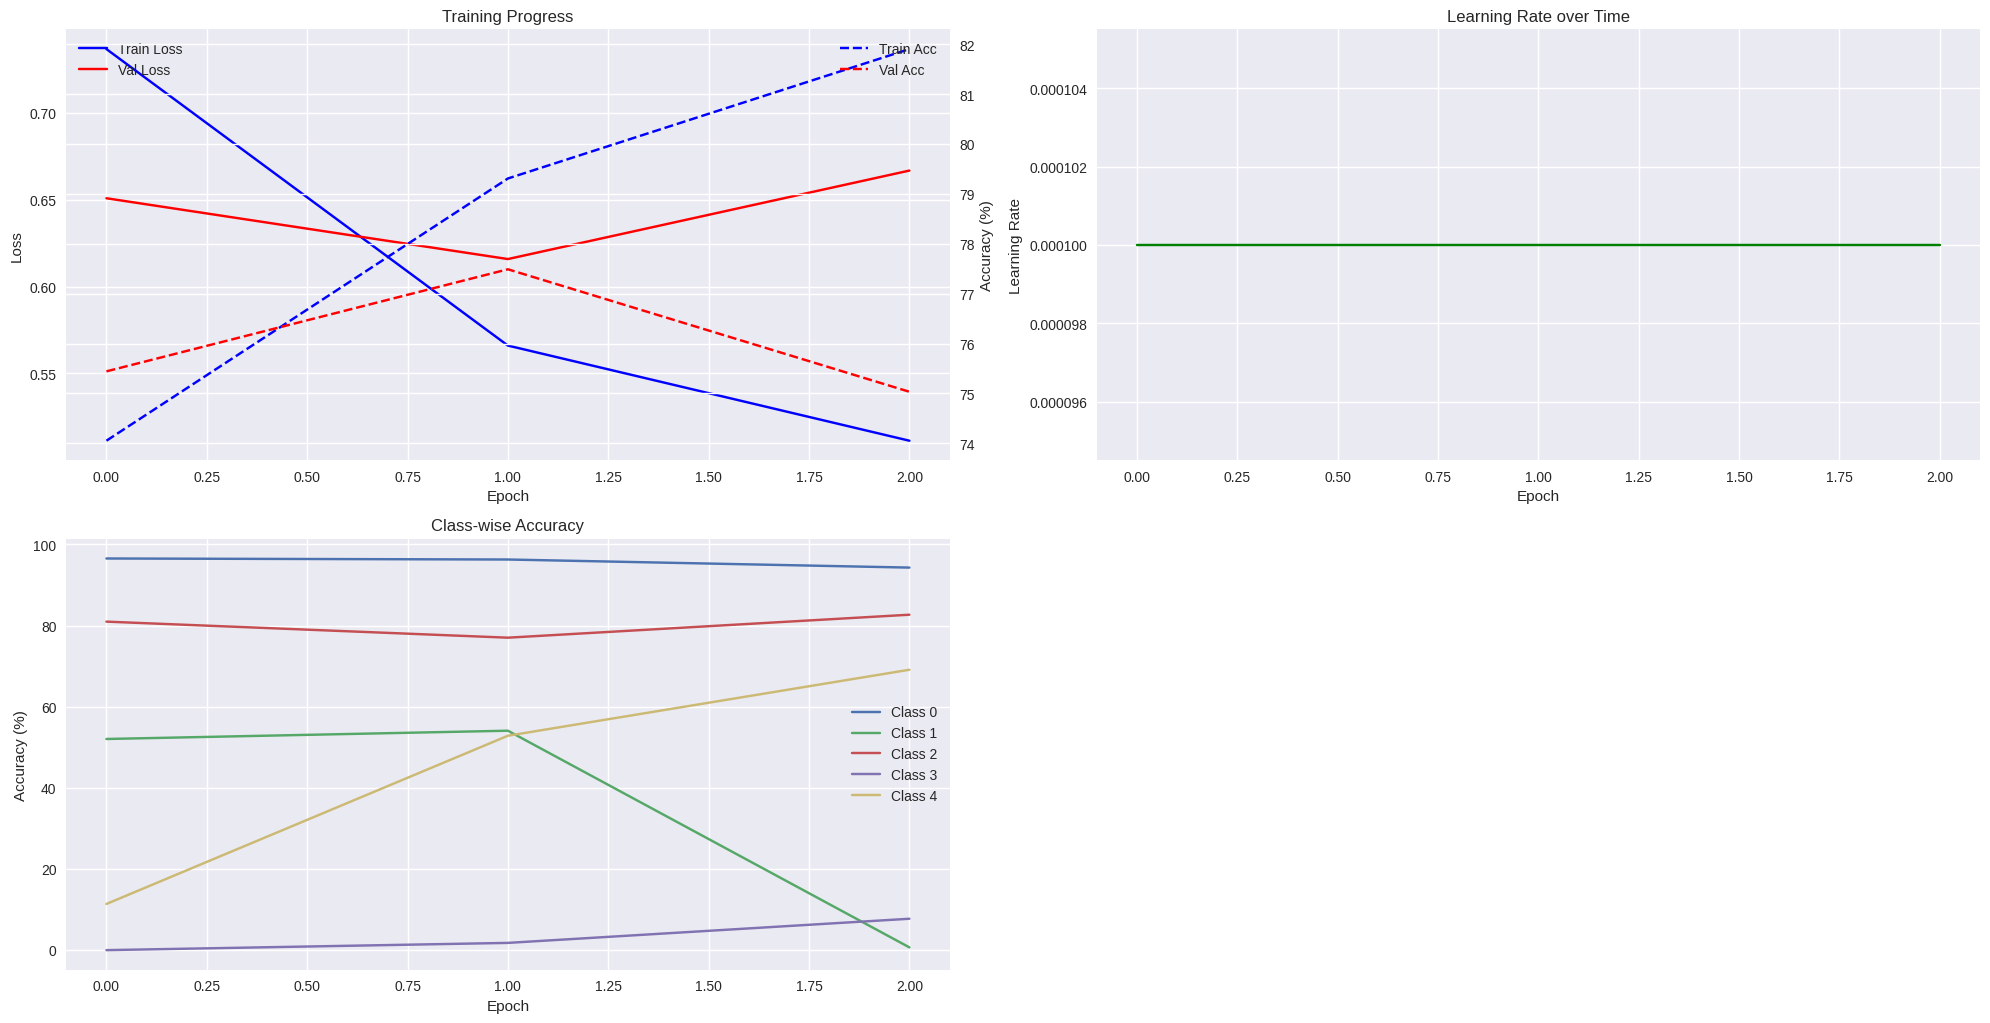

Train Loss: 0.5113, Train Acc: 81.91%
Val Loss: 0.6667, Val Acc: 75.03%


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch32-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-2a9b1155a7ee>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We r

Loaded best model successfully


Test Evaluation: 100%|██████████| 241/241 [00:35<00:00,  6.89it/s]


In [21]:
# Cell 20: Complete Usage Example
if __name__ == "__main__":
    # 1. Load and display data
    train_df, test_df = load_sample_data()
    display_sample_images(train_df, Config.TRAIN_PATH)
    
    # 2. Run training example
    run_training_example()
    
    # 3. Run evaluation example
    results = run_evaluation_example()
    
    # 4. Display final metrics if available
    if results and 'accuracy' in results:
        print(f"\nFinal Test Accuracy: {results['accuracy']:.2f}%")
        
        # Plot confusion matrix
        plot_confusion_matrix(results['true_labels'], results['predictions'])
        
        # Plot ROC curves
        plot_roc_curves(results['true_labels'], results['probabilities'])
